In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [1]:
import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)

import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)


new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Reset index for the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

pd.set_option('display.max_columns', None)  

df = df[~df.isin(['x']).any(axis=1)]

one_hot_encoded_data = pd.get_dummies(df, columns = ['Digester', 'Source', 'Type', 'Waste', 'Biomass']).astype(int)
# print(one_hot_encoded_data)
df_use = one_hot_encoded_data


## Base Model

### No CV

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset from DataFrame
def prepare_data(df, target_column):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, df, target_column):
        X, y = prepare_data(df, target_column)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = mse_loss(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test MSE Loss: {total_loss/len(test_loader):.4f}")

# Sample data (replace with your actual DataFrame)
df = pd.read_csv("Data/New_Data.csv")  # Load your dataset

target_column = "ACE-km"  # Define the target column
train_size = int(0.8 * len(df))
train_df = df_use[:train_size]
test_df = df_use[train_size:]

# Create datasets and data loaders
train_dataset = MicrobialDataset(train_df, target_column)
test_dataset = MicrobialDataset(test_df, target_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_df.shape[1] - 1  # Number of features
model = TransformerRegressionModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, device, epochs=50)
evaluate_model(model, test_loader, device)


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Loss: 249.5402
Epoch [2/50], Loss: 182.2895
Epoch [3/50], Loss: 171.2503
Epoch [4/50], Loss: 131.8796
Epoch [5/50], Loss: 171.4570
Epoch [6/50], Loss: 150.2130
Epoch [7/50], Loss: 164.2311
Epoch [8/50], Loss: 151.8343
Epoch [9/50], Loss: 152.8200
Epoch [10/50], Loss: 176.5534
Epoch [11/50], Loss: 153.3517
Epoch [12/50], Loss: 138.5383
Epoch [13/50], Loss: 155.9194
Epoch [14/50], Loss: 119.9991
Epoch [15/50], Loss: 129.6535
Epoch [16/50], Loss: 126.8164
Epoch [17/50], Loss: 144.9069
Epoch [18/50], Loss: 137.4190
Epoch [19/50], Loss: 127.4180
Epoch [20/50], Loss: 111.3035
Epoch [21/50], Loss: 120.6378
Epoch [22/50], Loss: 136.5822
Epoch [23/50], Loss: 125.1203
Epoch [24/50], Loss: 115.7630
Epoch [25/50], Loss: 128.2270
Epoch [26/50], Loss: 134.8051
Epoch [27/50], Loss: 103.0411
Epoch [28/50], Loss: 123.5336
Epoch [29/50], Loss: 137.4987
Epoch [30/50], Loss: 106.1658
Epoch [31/50], Loss: 108.5831
Epoch [32/50], Loss: 128.9393
Epoch [33/50], Loss: 122.4721
Epoch [34/50], Loss

### 5-Fold CV

Fold 1/5
Epoch [1/100], Loss: 238.1808
Epoch [2/100], Loss: 176.5608
Epoch [3/100], Loss: 156.5747
Epoch [4/100], Loss: 157.5534
Epoch [5/100], Loss: 167.2580
Epoch [6/100], Loss: 175.5359
Epoch [7/100], Loss: 170.8079
Epoch [8/100], Loss: 126.9103
Epoch [9/100], Loss: 159.2452
Epoch [10/100], Loss: 148.2066


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 120.4725
Epoch [12/100], Loss: 125.1022
Epoch [13/100], Loss: 117.0448
Epoch [14/100], Loss: 108.4766
Epoch [15/100], Loss: 138.3530
Epoch [16/100], Loss: 133.7853
Epoch [17/100], Loss: 133.6639
Epoch [18/100], Loss: 144.6780
Epoch [19/100], Loss: 119.2892
Epoch [20/100], Loss: 114.7506
Epoch [21/100], Loss: 143.2523
Epoch [22/100], Loss: 132.1525
Epoch [23/100], Loss: 113.7362
Epoch [24/100], Loss: 116.8167
Epoch [25/100], Loss: 107.4339
Epoch [26/100], Loss: 117.4850
Epoch [27/100], Loss: 100.7172
Epoch [28/100], Loss: 141.3075
Epoch [29/100], Loss: 131.1488
Epoch [30/100], Loss: 128.6923
Epoch [31/100], Loss: 125.7288
Epoch [32/100], Loss: 112.3759
Epoch [33/100], Loss: 108.9257
Epoch [34/100], Loss: 99.0423
Epoch [35/100], Loss: 99.6177
Epoch [36/100], Loss: 110.2022
Epoch [37/100], Loss: 106.2557
Epoch [38/100], Loss: 95.7192
Epoch [39/100], Loss: 108.1756
Epoch [40/100], Loss: 121.6559
Epoch [41/100], Loss: 95.8199
Epoch [42/100], Loss: 120.1204
Epoch [43/10

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 145.4388
Epoch [11/100], Loss: 134.1069
Epoch [12/100], Loss: 128.5184
Epoch [13/100], Loss: 140.5785
Epoch [14/100], Loss: 130.9865
Epoch [15/100], Loss: 111.8498
Epoch [16/100], Loss: 112.4445
Epoch [17/100], Loss: 121.7905
Epoch [18/100], Loss: 104.3625
Epoch [19/100], Loss: 118.8215
Epoch [20/100], Loss: 119.8123
Epoch [21/100], Loss: 98.6462
Epoch [22/100], Loss: 107.1371
Epoch [23/100], Loss: 101.0577
Epoch [24/100], Loss: 132.0947
Epoch [25/100], Loss: 124.7626
Epoch [26/100], Loss: 108.7583
Epoch [27/100], Loss: 120.8348
Epoch [28/100], Loss: 99.2602
Epoch [29/100], Loss: 90.9467
Epoch [30/100], Loss: 110.2077
Epoch [31/100], Loss: 102.0060
Epoch [32/100], Loss: 106.0666
Epoch [33/100], Loss: 116.7716
Epoch [34/100], Loss: 82.3677
Epoch [35/100], Loss: 84.8640
Epoch [36/100], Loss: 74.5087
Epoch [37/100], Loss: 72.8899
Epoch [38/100], Loss: 98.5629
Epoch [39/100], Loss: 94.1863
Epoch [40/100], Loss: 69.1894
Epoch [41/100], Loss: 71.4606
Epoch [42/100], Los

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [9/100], Loss: 152.9023
Epoch [10/100], Loss: 129.1934
Epoch [11/100], Loss: 137.6217
Epoch [12/100], Loss: 130.7216
Epoch [13/100], Loss: 161.0319
Epoch [14/100], Loss: 129.3385
Epoch [15/100], Loss: 124.8813
Epoch [16/100], Loss: 132.2075
Epoch [17/100], Loss: 115.5376
Epoch [18/100], Loss: 117.7805
Epoch [19/100], Loss: 140.8043
Epoch [20/100], Loss: 135.9319
Epoch [21/100], Loss: 112.3929
Epoch [22/100], Loss: 133.4423
Epoch [23/100], Loss: 125.1042
Epoch [24/100], Loss: 100.4411
Epoch [25/100], Loss: 115.1026
Epoch [26/100], Loss: 133.7503
Epoch [27/100], Loss: 131.3440
Epoch [28/100], Loss: 113.6654
Epoch [29/100], Loss: 104.1160
Epoch [30/100], Loss: 107.1063
Epoch [31/100], Loss: 126.5838
Epoch [32/100], Loss: 103.0228
Epoch [33/100], Loss: 102.3174
Epoch [34/100], Loss: 117.7142
Epoch [35/100], Loss: 116.1181
Epoch [36/100], Loss: 126.1557
Epoch [37/100], Loss: 112.2126
Epoch [38/100], Loss: 97.5309
Epoch [39/100], Loss: 112.6258
Epoch [40/100], Loss: 105.8921
Epoch [41/

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100], Loss: 219.4329
Epoch [2/100], Loss: 152.2266
Epoch [3/100], Loss: 136.8840
Epoch [4/100], Loss: 147.5929
Epoch [5/100], Loss: 141.0299
Epoch [6/100], Loss: 121.5162
Epoch [7/100], Loss: 113.6887
Epoch [8/100], Loss: 126.7374
Epoch [9/100], Loss: 140.8054
Epoch [10/100], Loss: 97.0071
Epoch [11/100], Loss: 120.9480
Epoch [12/100], Loss: 145.8096
Epoch [13/100], Loss: 104.1878
Epoch [14/100], Loss: 107.6653
Epoch [15/100], Loss: 137.5069
Epoch [16/100], Loss: 97.8253
Epoch [17/100], Loss: 125.1268
Epoch [18/100], Loss: 132.3521
Epoch [19/100], Loss: 127.6622
Epoch [20/100], Loss: 127.9230
Epoch [21/100], Loss: 127.2261
Epoch [22/100], Loss: 106.5207
Epoch [23/100], Loss: 107.2032
Epoch [24/100], Loss: 94.8337
Epoch [25/100], Loss: 96.8975
Epoch [26/100], Loss: 96.1797
Epoch [27/100], Loss: 115.3983
Epoch [28/100], Loss: 89.6379
Epoch [29/100], Loss: 114.2249
Epoch [30/100], Loss: 114.3484
Epoch [31/100], Loss: 94.1517
Epoch [32/100], Loss: 95.4581
Epoch [33/100], Loss: 83.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [6/100], Loss: 103.0867
Epoch [7/100], Loss: 122.9314
Epoch [8/100], Loss: 117.1385
Epoch [9/100], Loss: 115.4375
Epoch [10/100], Loss: 101.1121
Epoch [11/100], Loss: 89.3370
Epoch [12/100], Loss: 98.5043
Epoch [13/100], Loss: 101.9020
Epoch [14/100], Loss: 83.2457
Epoch [15/100], Loss: 87.3978
Epoch [16/100], Loss: 75.1025
Epoch [17/100], Loss: 87.0224
Epoch [18/100], Loss: 87.6564
Epoch [19/100], Loss: 75.7465
Epoch [20/100], Loss: 79.7729
Epoch [21/100], Loss: 73.6538
Epoch [22/100], Loss: 91.7034
Epoch [23/100], Loss: 84.1714
Epoch [24/100], Loss: 85.6383
Epoch [25/100], Loss: 88.8065
Epoch [26/100], Loss: 90.2743
Epoch [27/100], Loss: 78.0667
Epoch [28/100], Loss: 88.5324
Epoch [29/100], Loss: 76.9079
Epoch [30/100], Loss: 82.7719
Epoch [31/100], Loss: 92.8133
Epoch [32/100], Loss: 96.2540
Epoch [33/100], Loss: 76.1081
Epoch [34/100], Loss: 97.6464
Epoch [35/100], Loss: 80.6375
Epoch [36/100], Loss: 94.1942
Epoch [37/100], Loss: 73.7847
Epoch [38/100], Loss: 85.0417
Epoch [3

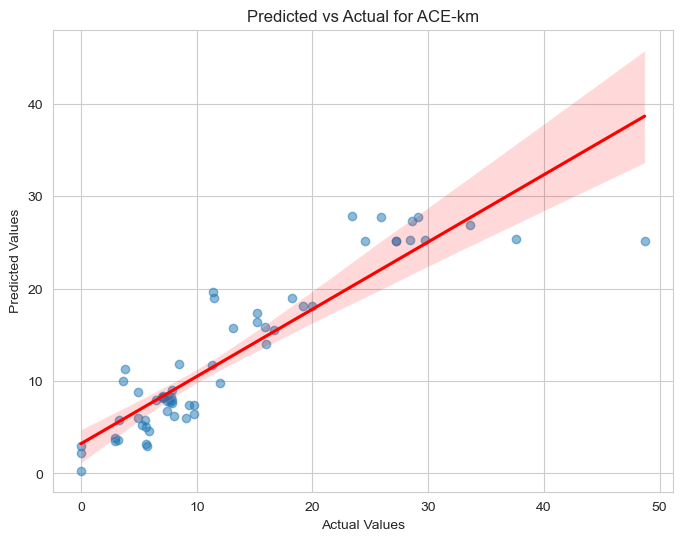

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=16, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


Fold 1/5
Epoch [1/100], Loss: 238.2786
Epoch [2/100], Loss: 169.1809
Epoch [3/100], Loss: 184.4600
Epoch [4/100], Loss: 163.6804
Epoch [5/100], Loss: 151.7298
Epoch [6/100], Loss: 146.4829
Epoch [7/100], Loss: 165.6030
Epoch [8/100], Loss: 154.9641
Epoch [9/100], Loss: 116.5766
Epoch [10/100], Loss: 150.1086


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 177.8302
Epoch [12/100], Loss: 125.3276
Epoch [13/100], Loss: 144.5401
Epoch [14/100], Loss: 156.5723
Epoch [15/100], Loss: 127.0285
Epoch [16/100], Loss: 153.6550
Epoch [17/100], Loss: 138.6663
Epoch [18/100], Loss: 137.7980
Epoch [19/100], Loss: 138.6865
Epoch [20/100], Loss: 152.3131
Epoch [21/100], Loss: 121.4910
Epoch [22/100], Loss: 109.7403
Epoch [23/100], Loss: 136.5576
Epoch [24/100], Loss: 111.9325
Epoch [25/100], Loss: 132.2966
Epoch [26/100], Loss: 122.5877
Epoch [27/100], Loss: 130.5868
Epoch [28/100], Loss: 128.5789
Epoch [29/100], Loss: 132.2475
Epoch [30/100], Loss: 109.3085
Epoch [31/100], Loss: 122.8684
Epoch [32/100], Loss: 101.4562
Epoch [33/100], Loss: 116.0082
Epoch [34/100], Loss: 123.1167
Epoch [35/100], Loss: 112.8298
Epoch [36/100], Loss: 108.8824
Epoch [37/100], Loss: 117.5599
Epoch [38/100], Loss: 106.5300
Epoch [39/100], Loss: 115.3471
Epoch [40/100], Loss: 106.9404
Epoch [41/100], Loss: 133.7758
Epoch [42/100], Loss: 130.0946
Epoch [4

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/100], Loss: 169.5875
Epoch [8/100], Loss: 124.5226
Epoch [9/100], Loss: 134.7316
Epoch [10/100], Loss: 160.6457
Epoch [11/100], Loss: 127.8248
Epoch [12/100], Loss: 149.6157
Epoch [13/100], Loss: 106.3198
Epoch [14/100], Loss: 128.5958
Epoch [15/100], Loss: 121.5677
Epoch [16/100], Loss: 148.0456
Epoch [17/100], Loss: 116.5908
Epoch [18/100], Loss: 111.0045
Epoch [19/100], Loss: 116.1016
Epoch [20/100], Loss: 124.6410
Epoch [21/100], Loss: 120.7796
Epoch [22/100], Loss: 109.4841
Epoch [23/100], Loss: 122.8428
Epoch [24/100], Loss: 103.8637
Epoch [25/100], Loss: 116.4005
Epoch [26/100], Loss: 104.3111
Epoch [27/100], Loss: 129.5189
Epoch [28/100], Loss: 123.9738
Epoch [29/100], Loss: 106.5469
Epoch [30/100], Loss: 103.4571
Epoch [31/100], Loss: 118.1911
Epoch [32/100], Loss: 89.2322
Epoch [33/100], Loss: 116.4855
Epoch [34/100], Loss: 87.3908
Epoch [35/100], Loss: 96.2158
Epoch [36/100], Loss: 97.3369
Epoch [37/100], Loss: 94.5330
Epoch [38/100], Loss: 87.0967
Epoch [39/100], L

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [8/100], Loss: 146.7071
Epoch [9/100], Loss: 150.2779
Epoch [10/100], Loss: 135.8591
Epoch [11/100], Loss: 147.4140
Epoch [12/100], Loss: 135.5543
Epoch [13/100], Loss: 154.1634
Epoch [14/100], Loss: 121.1714
Epoch [15/100], Loss: 116.2016
Epoch [16/100], Loss: 128.3818
Epoch [17/100], Loss: 122.3728
Epoch [18/100], Loss: 132.3987
Epoch [19/100], Loss: 151.4215
Epoch [20/100], Loss: 113.3835
Epoch [21/100], Loss: 134.0097
Epoch [22/100], Loss: 135.7180
Epoch [23/100], Loss: 129.0506
Epoch [24/100], Loss: 119.6333
Epoch [25/100], Loss: 135.2792
Epoch [26/100], Loss: 104.3027
Epoch [27/100], Loss: 111.3158
Epoch [28/100], Loss: 121.8571
Epoch [29/100], Loss: 107.5517
Epoch [30/100], Loss: 113.1316
Epoch [31/100], Loss: 123.6372
Epoch [32/100], Loss: 137.9787
Epoch [33/100], Loss: 107.1770
Epoch [34/100], Loss: 106.3064
Epoch [35/100], Loss: 136.8722
Epoch [36/100], Loss: 115.4805
Epoch [37/100], Loss: 136.3201
Epoch [38/100], Loss: 111.6697
Epoch [39/100], Loss: 99.6008
Epoch [40/1

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/100], Loss: 144.5953
Epoch [3/100], Loss: 156.5597
Epoch [4/100], Loss: 138.2310
Epoch [5/100], Loss: 114.0622
Epoch [6/100], Loss: 114.5107
Epoch [7/100], Loss: 148.4585
Epoch [8/100], Loss: 143.8513
Epoch [9/100], Loss: 127.9861
Epoch [10/100], Loss: 111.8543
Epoch [11/100], Loss: 140.4861
Epoch [12/100], Loss: 135.3399
Epoch [13/100], Loss: 132.3668
Epoch [14/100], Loss: 102.0560
Epoch [15/100], Loss: 98.9891
Epoch [16/100], Loss: 131.1198
Epoch [17/100], Loss: 126.7894
Epoch [18/100], Loss: 99.1103
Epoch [19/100], Loss: 113.4575
Epoch [20/100], Loss: 134.6061
Epoch [21/100], Loss: 87.3645
Epoch [22/100], Loss: 89.5563
Epoch [23/100], Loss: 96.7445
Epoch [24/100], Loss: 113.1453
Epoch [25/100], Loss: 87.5937
Epoch [26/100], Loss: 93.7930
Epoch [27/100], Loss: 94.5150
Epoch [28/100], Loss: 117.6349
Epoch [29/100], Loss: 93.7797
Epoch [30/100], Loss: 90.7756
Epoch [31/100], Loss: 89.2640
Epoch [32/100], Loss: 88.2276
Epoch [33/100], Loss: 90.4361
Epoch [34/100], Loss: 89.8293

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 100.9367
Epoch [11/100], Loss: 96.5197
Epoch [12/100], Loss: 118.1196
Epoch [13/100], Loss: 90.9772
Epoch [14/100], Loss: 108.6818
Epoch [15/100], Loss: 89.9468
Epoch [16/100], Loss: 94.0108
Epoch [17/100], Loss: 104.3791
Epoch [18/100], Loss: 86.3713
Epoch [19/100], Loss: 92.4080
Epoch [20/100], Loss: 91.0579
Epoch [21/100], Loss: 100.1344
Epoch [22/100], Loss: 82.8935
Epoch [23/100], Loss: 90.0825
Epoch [24/100], Loss: 78.7442
Epoch [25/100], Loss: 76.8031
Epoch [26/100], Loss: 76.0462
Epoch [27/100], Loss: 106.3921
Epoch [28/100], Loss: 93.3103
Epoch [29/100], Loss: 92.4289
Epoch [30/100], Loss: 87.5206
Epoch [31/100], Loss: 77.5486
Epoch [32/100], Loss: 93.8975
Epoch [33/100], Loss: 85.8946
Epoch [34/100], Loss: 86.1426
Epoch [35/100], Loss: 92.8108
Epoch [36/100], Loss: 95.0034
Epoch [37/100], Loss: 88.4009
Epoch [38/100], Loss: 89.5906
Epoch [39/100], Loss: 75.3094
Epoch [40/100], Loss: 81.6892
Epoch [41/100], Loss: 75.0541
Epoch [42/100], Loss: 83.1178
Epoc

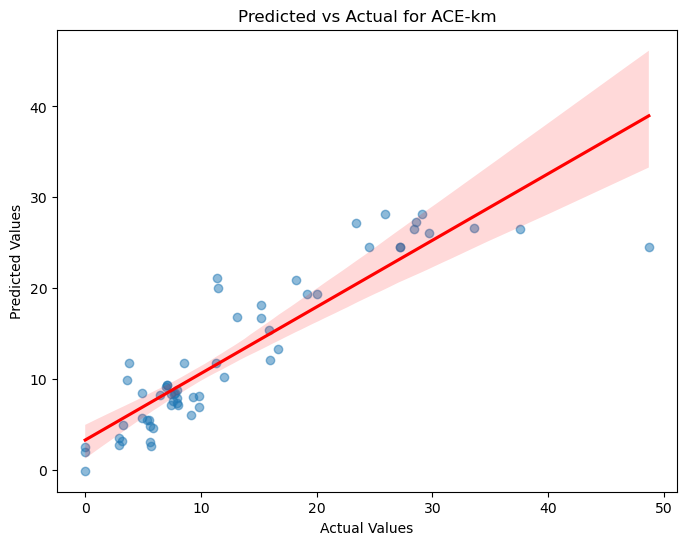

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


### LOGO


LOGO Fold 1/18: Excluding Digester Group 0


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/200], Loss: 274.0208
Epoch [2/200], Loss: 176.3845
Epoch [3/200], Loss: 182.1474
Epoch [4/200], Loss: 152.6469
Epoch [5/200], Loss: 171.5730
Epoch [6/200], Loss: 151.7819
Epoch [7/200], Loss: 160.2554
Epoch [8/200], Loss: 158.0627
Epoch [9/200], Loss: 149.6841
Epoch [10/200], Loss: 138.1664
Epoch [11/200], Loss: 129.4156
Epoch [12/200], Loss: 120.5059
Epoch [13/200], Loss: 143.3707
Epoch [14/200], Loss: 131.0015
Epoch [15/200], Loss: 134.7587
Epoch [16/200], Loss: 130.6476
Epoch [17/200], Loss: 123.3188
Epoch [18/200], Loss: 131.4559
Epoch [19/200], Loss: 126.0245
Epoch [20/200], Loss: 131.8539
Epoch [21/200], Loss: 118.5525
Epoch [22/200], Loss: 107.3596
Epoch [23/200], Loss: 112.7438
Epoch [24/200], Loss: 102.2396
Epoch [25/200], Loss: 115.9364
Epoch [26/200], Loss: 109.2756
Epoch [27/200], Loss: 118.8904
Epoch [28/200], Loss: 103.7401
Epoch [29/200], Loss: 112.1518
Epoch [30/200], Loss: 105.4932
Epoch [31/200], Loss: 102.2486
Epoch [32/200], Loss: 110.4299
Epoch [33/200], L

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/200], Loss: 138.7666
Epoch [8/200], Loss: 130.5925
Epoch [9/200], Loss: 159.6890
Epoch [10/200], Loss: 128.0217
Epoch [11/200], Loss: 133.5487
Epoch [12/200], Loss: 151.0818
Epoch [13/200], Loss: 117.0131
Epoch [14/200], Loss: 127.4824
Epoch [15/200], Loss: 129.6968
Epoch [16/200], Loss: 136.0831
Epoch [17/200], Loss: 122.6527
Epoch [18/200], Loss: 117.5700
Epoch [19/200], Loss: 118.7072
Epoch [20/200], Loss: 116.1406
Epoch [21/200], Loss: 130.3233
Epoch [22/200], Loss: 134.6403
Epoch [23/200], Loss: 112.1883
Epoch [24/200], Loss: 118.7582
Epoch [25/200], Loss: 121.0535
Epoch [26/200], Loss: 112.6610
Epoch [27/200], Loss: 125.2717
Epoch [28/200], Loss: 106.7731
Epoch [29/200], Loss: 108.0427
Epoch [30/200], Loss: 113.1635
Epoch [31/200], Loss: 111.9594
Epoch [32/200], Loss: 112.0232
Epoch [33/200], Loss: 119.5640
Epoch [34/200], Loss: 107.2174
Epoch [35/200], Loss: 98.8305
Epoch [36/200], Loss: 122.7919
Epoch [37/200], Loss: 115.7151
Epoch [38/200], Loss: 115.1299
Epoch [39/20

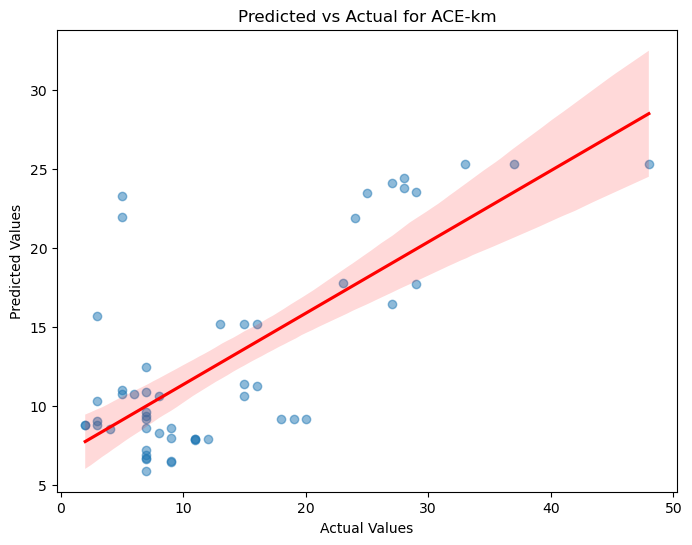

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# "Digester_BF", "Digester_GB",

# Identify digester group columns
digester_columns = [col for col in target_columns if col.startswith("Digester_")]

# Load dataset and extract groups
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract digester groups by finding the highest one-hot encoded value
    digester_groups = df[digester_columns].idxmax(axis=1)  # Assign group based on max index
    
    # Convert group names to numerical indices
    unique_groups = {name: idx for idx, name in enumerate(digester_groups.unique())}
    digester_groups = digester_groups.map(unique_groups)  # Convert to numerical labels

    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    return X, y, digester_groups.values

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=32, num_layers=4, dim_feedforward=512, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Leave-One-Group-Out Cross-Validation (LOGO)
def leave_one_group_out_cv(df, target_column, epochs=200):
    X, y, groups = prepare_data(df, target_column)
    logo = LeaveOneGroupOut()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []  # Collect all validation points

    for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, groups)):
        print(f"\nLOGO Fold {fold+1}/{len(np.unique(groups))}: Excluding Digester Group {groups[val_idx][0]}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                all_predictions.extend(predictions)  # Collect all validation predictions
                all_actuals.extend(y_batch.cpu().numpy())  # Collect all validation true values

        print(f"LOGO Fold {fold+1} completed.")

    # Calculate MSE and R² only after all folds are processed
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)

    print(f"\nFinal LOGO-CV Results: MSE = {mse:.4f}, R² = {r2:.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform LOGO-CV for a target column
target_column = "ACE-km"
leave_one_group_out_cv(df_use, target_column)

## Different Model achitectures

In [11]:
import torch
import torch.nn as nn

class TabTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): The number of features (each treated as a token).
            d_model (int): The embedding dimension for each token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(TabTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, input_dim)
        """
        batch_size, num_features = x.size()
        
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)

import torch
import torch.nn as nn

class LightweightTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=1, dim_feedforward=128, dropout=0.1):
        super(LightweightTransformerRegression, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)


class MidLevelTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): Number of features per sample.
            d_model (int): Embedding dimension for each feature token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(MidLevelTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, input_dim)
        Returns:
            Tensor of shape (batch_size,) with regression predictions.
        """
        batch_size, num_features = x.size()
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)


## Complex Model

### No CV

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the Transformer model
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        self.feature_embedding = nn.Linear(1, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Dataset preparation functions
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, scaler

class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_loss = float('inf')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val).item() * X_val.size(0)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}')
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    print('Training complete')
    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Main execution
if __name__ == "__main__":
    # Load your data
    df_use = pd.read_csv('Data/New_data.csv')  # Replace with your data loading
    
    # Prepare data
    target_column = "ACE-km"
    X, y, scaler = prepare_data(df_use, target_column)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = MicrobialDataset(X_train, y_train)
    val_dataset = MicrobialDataset(X_val, y_val)
    
    # Create dataloaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model
    num_features = X_train.shape[1]
    model = TabularTransformer(
        num_features=num_features,
        d_model=64,
        nhead=4,
        num_layers=2,
        dropout=0.2
    )
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # Train the model
    trained_model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=50
    )
    
    # Evaluation
    trained_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        predictions = trained_model(X_val_tensor).cpu().numpy()
        
        # Calculate metrics
        mse = np.mean((predictions - y_val) ** 2)
        mae = np.mean(np.abs(predictions - y_val))
        print(f'\nFinal Validation Metrics:')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'RMSE: {np.sqrt(mse):.4f}')

Epoch 1/50 - Train Loss: 293.3357 - Val Loss: 189.9779
Epoch 2/50 - Train Loss: 274.7399 - Val Loss: 178.2214
Epoch 3/50 - Train Loss: 262.5762 - Val Loss: 169.2988
Epoch 4/50 - Train Loss: 250.3853 - Val Loss: 161.5754
Epoch 5/50 - Train Loss: 248.8328 - Val Loss: 154.2256
Epoch 6/50 - Train Loss: 238.9467 - Val Loss: 147.1032
Epoch 7/50 - Train Loss: 228.5577 - Val Loss: 139.9063
Epoch 8/50 - Train Loss: 226.3169 - Val Loss: 133.2458
Epoch 9/50 - Train Loss: 218.5774 - Val Loss: 127.2677
Epoch 10/50 - Train Loss: 211.8984 - Val Loss: 122.1929
Epoch 11/50 - Train Loss: 201.6307 - Val Loss: 117.5137
Epoch 12/50 - Train Loss: 194.0761 - Val Loss: 113.2108
Epoch 13/50 - Train Loss: 194.9467 - Val Loss: 109.3189
Epoch 14/50 - Train Loss: 186.8673 - Val Loss: 105.7894
Epoch 15/50 - Train Loss: 182.3045 - Val Loss: 102.3608
Epoch 16/50 - Train Loss: 174.3950 - Val Loss: 98.8562
Epoch 17/50 - Train Loss: 174.4861 - Val Loss: 95.8380
Epoch 18/50 - Train Loss: 177.2390 - Val Loss: 93.3505
Epoc

### LOGO


LOGO Fold 1/18: Excluding Digester Group 0
Epoch 1/50 - Train Loss: 295.6415 - Val Loss: 9.1222
Epoch 2/50 - Train Loss: 295.8872 - Val Loss: 4.9212
Epoch 3/50 - Train Loss: 263.4765 - Val Loss: 2.2790
Epoch 4/50 - Train Loss: 243.6227 - Val Loss: 0.9045
Epoch 5/50 - Train Loss: 243.6521 - Val Loss: 0.2464
Epoch 6/50 - Train Loss: 211.3891 - Val Loss: 0.0266
Epoch 7/50 - Train Loss: 224.1974 - Val Loss: 0.0915
Epoch 8/50 - Train Loss: 213.3746 - Val Loss: 0.3808
Epoch 9/50 - Train Loss: 210.2859 - Val Loss: 0.9115
Epoch 10/50 - Train Loss: 196.3162 - Val Loss: 1.7091
Epoch 11/50 - Train Loss: 208.2766 - Val Loss: 2.8015
Epoch 12/50 - Train Loss: 199.7261 - Val Loss: 4.2411
Epoch 13/50 - Train Loss: 192.5031 - Val Loss: 4.4011
Epoch 14/50 - Train Loss: 190.2002 - Val Loss: 4.5626
Epoch 15/50 - Train Loss: 174.0821 - Val Loss: 4.7319
Epoch 16/50 - Train Loss: 195.4641 - Val Loss: 4.9070
Early stopping at epoch 16
LOGO Fold 1 completed.

LOGO Fold 2/18: Excluding Digester Group 1
Epoch 1

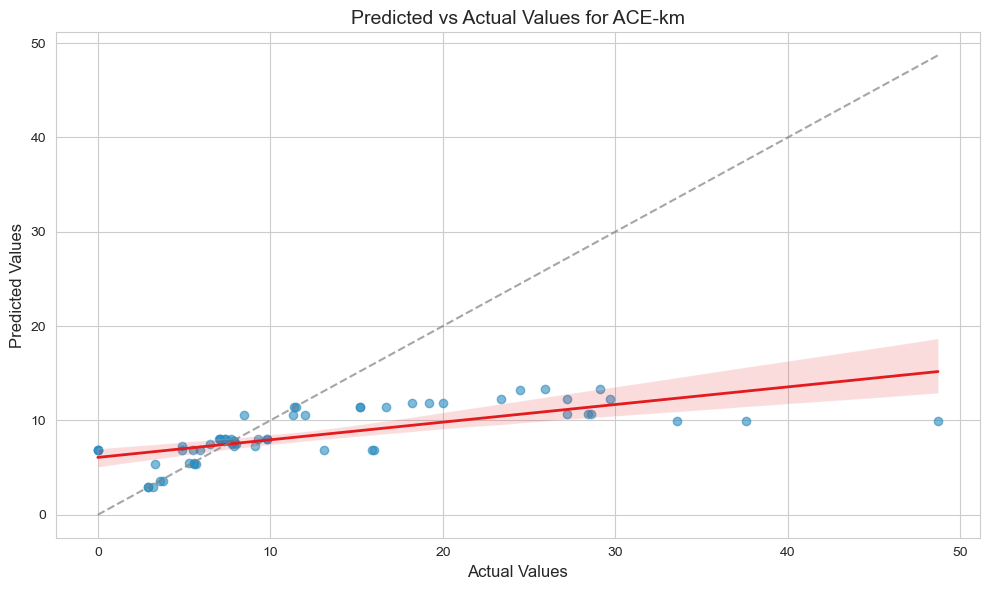

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Identify digester group columns
digester_columns = [col for col in target_columns if col.startswith("Digester_")]

# Load dataset and extract groups
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract digester groups by finding the highest one-hot encoded value
    digester_groups = df[digester_columns].idxmax(axis=1)
    unique_groups = {name: idx for idx, name in enumerate(digester_groups.unique())}
    digester_groups = digester_groups.map(unique_groups)

    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    # Add feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, digester_groups.values

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Enhanced Transformer Model (your architecture)
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        # Feature embedding layer
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Modified LOGO-CV with improved training
def leave_one_group_out_cv(df, target_column, epochs=100):
    X, y, groups = prepare_data(df, target_column)
    logo = LeaveOneGroupOut()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []

    for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, groups)):
        print(f"\nLOGO Fold {fold+1}/{len(np.unique(groups))}: Excluding Digester Group {groups[val_idx][0]}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        num_features = X_train.shape[1]
        model = TabularTransformer(
            num_features=num_features,
            d_model=64,
            nhead=4,
            num_layers=2,
            dropout=0.2
        ).to(device)
        
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        # Training loop with early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    outputs = model(X_val_batch)
                    val_loss += criterion(outputs, y_val_batch).item()
            
            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model for this fold
        model.load_state_dict(torch.load('best_model.pth'))
        
        # Final validation prediction
        model.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            fold_preds = model(val_tensor).cpu().numpy()
            all_predictions.extend(fold_preds)
            all_actuals.extend(y_val)

        print(f"LOGO Fold {fold+1} completed.")

    # Calculate final metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(all_actuals) - np.array(all_predictions)))

    print(f"\nFinal LOGO-CV Metrics for {target_column}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Enhanced visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.regplot(x=all_actuals, y=all_predictions, 
                    scatter_kws={'alpha':0.6, 'color':'#2b8cbe'}, 
                    line_kws={'color':'#e41a1c', 'lw':2})
    
    ax.plot([min(all_actuals), max(all_actuals)], 
            [min(all_actuals), max(all_actuals)], 
            '--', color='gray', alpha=0.7)
    
    plt.title(f"Predicted vs Actual Values for {target_column}", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your dataset
    df_use = pd.read_csv("Data/New_data.csv")  # Update with your actual path
    
    # Run LOGO-CV for target column
    target_column = "ACE-km"
    leave_one_group_out_cv(df_use, target_column, epochs=100)

### 5-Fold CV


Fold 1/5
Epoch 1/100 - Train Loss: 288.6538 - Val Loss: 199.3862
Epoch 2/100 - Train Loss: 280.9319 - Val Loss: 190.0163
Epoch 3/100 - Train Loss: 273.6458 - Val Loss: 181.2045
Epoch 4/100 - Train Loss: 269.1305 - Val Loss: 173.1799
Epoch 5/100 - Train Loss: 255.4209 - Val Loss: 165.6258
Epoch 6/100 - Train Loss: 256.8691 - Val Loss: 158.6141
Epoch 7/100 - Train Loss: 245.9008 - Val Loss: 152.1739
Epoch 8/100 - Train Loss: 234.5455 - Val Loss: 146.0296
Epoch 9/100 - Train Loss: 229.6543 - Val Loss: 139.8458
Epoch 10/100 - Train Loss: 228.1484 - Val Loss: 133.8368
Epoch 11/100 - Train Loss: 211.1736 - Val Loss: 128.3446
Epoch 12/100 - Train Loss: 205.1974 - Val Loss: 123.2065
Epoch 13/100 - Train Loss: 202.1957 - Val Loss: 118.4722
Epoch 14/100 - Train Loss: 202.9127 - Val Loss: 114.2863
Epoch 15/100 - Train Loss: 198.1690 - Val Loss: 110.3274
Epoch 16/100 - Train Loss: 195.3354 - Val Loss: 106.6278
Epoch 17/100 - Train Loss: 189.8399 - Val Loss: 103.1698
Epoch 18/100 - Train Loss: 181

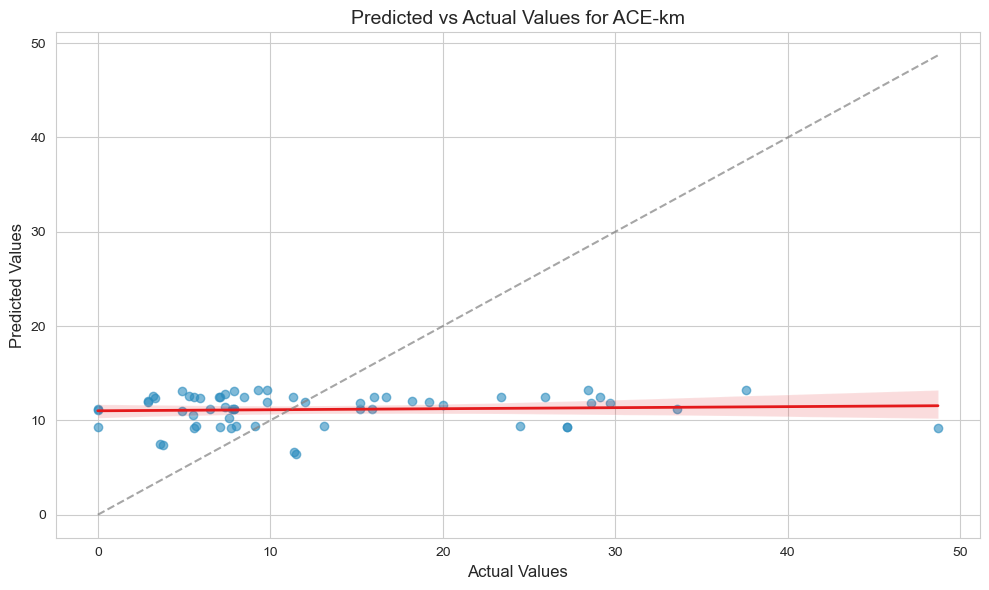

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_CB", "Digester_CP", "Digester_FD",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset and prepare features
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer Model (same as before)
class TabularTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        self.feature_embedding = nn.Linear(1, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x_emb = self.feature_embedding(x.unsqueeze(-1))
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x_emb], dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.regressor(cls_output).squeeze()

# Modified 5-fold CV training
def five_fold_cv(df, target_column, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_actuals, all_predictions = [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/5")
        
        # Scale features within fold to prevent data leakage
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X[train_idx])
        X_val = scaler.transform(X[val_idx])
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)

        num_features = X_train.shape[1]
        model = TabularTransformer(
            num_features=num_features,
            d_model=64,
            nhead=4,
            num_layers=2,
            dropout=0.2
        ).to(device)
        
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        # Training loop with early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    outputs = model(X_val_batch)
                    val_loss += criterion(outputs, y_val_batch).item()
            
            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model for this fold
        model.load_state_dict(torch.load('best_model.pth'))
        
        # Final validation prediction
        model.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            fold_preds = model(val_tensor).cpu().numpy()
            all_predictions.extend(fold_preds)
            all_actuals.extend(y_val)

        print(f"Fold {fold+1} completed.")

    # Calculate final metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(all_actuals) - np.array(all_predictions)))

    print(f"\nFinal 5-Fold CV Metrics for {target_column}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.regplot(x=all_actuals, y=all_predictions, 
                    scatter_kws={'alpha':0.6, 'color':'#2b8cbe'}, 
                    line_kws={'color':'#e41a1c', 'lw':2})
    
    ax.plot([min(all_actuals), max(all_actuals)], 
            [min(all_actuals), max(all_actuals)], 
            '--', color='gray', alpha=0.7)
    
    plt.title(f"Predicted vs Actual Values for {target_column}", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your dataset
    df_use = pd.read_csv("Data/New_data.csv")  # Update with your actual path
    
    # Run 5-fold CV for target column
    target_column = "ACE-km"
    five_fold_cv(df_use, target_column, epochs=100)

## TabTransfromer


Fold 1/5
Epoch [1/50] Loss: 264.7889
Epoch [2/50] Loss: 292.4122
Epoch [3/50] Loss: 240.5122
Epoch [4/50] Loss: 294.9638
Epoch [5/50] Loss: 288.0151
Epoch [6/50] Loss: 215.1601
Epoch [7/50] Loss: 237.9567
Epoch [8/50] Loss: 226.6932
Epoch [9/50] Loss: 245.5133
Epoch [10/50] Loss: 206.7734
Epoch [11/50] Loss: 263.8934
Epoch [12/50] Loss: 209.3491
Epoch [13/50] Loss: 227.3278
Epoch [14/50] Loss: 212.9247
Epoch [15/50] Loss: 189.2515
Epoch [16/50] Loss: 206.7507


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [17/50] Loss: 191.6990
Epoch [18/50] Loss: 165.8552
Epoch [19/50] Loss: 202.7935
Epoch [20/50] Loss: 190.0407
Epoch [21/50] Loss: 160.1867
Epoch [22/50] Loss: 141.0794
Epoch [23/50] Loss: 142.8981
Epoch [24/50] Loss: 152.3619
Epoch [25/50] Loss: 153.4437
Epoch [26/50] Loss: 122.7745
Epoch [27/50] Loss: 150.2747
Epoch [28/50] Loss: 147.0594
Epoch [29/50] Loss: 109.6321
Epoch [30/50] Loss: 127.5550
Epoch [31/50] Loss: 124.4652
Epoch [32/50] Loss: 133.5394
Epoch [33/50] Loss: 112.9122
Epoch [34/50] Loss: 95.0982
Epoch [35/50] Loss: 91.4605
Epoch [36/50] Loss: 87.9489
Epoch [37/50] Loss: 111.1448
Epoch [38/50] Loss: 92.5503
Epoch [39/50] Loss: 66.4592
Epoch [40/50] Loss: 70.4315
Epoch [41/50] Loss: 65.5319
Epoch [42/50] Loss: 79.7717
Epoch [43/50] Loss: 51.4427
Epoch [44/50] Loss: 60.3736
Epoch [45/50] Loss: 43.7925
Epoch [46/50] Loss: 62.8064
Epoch [47/50] Loss: 62.7621
Epoch [48/50] Loss: 58.9982
Epoch [49/50] Loss: 52.3297
Epoch [50/50] Loss: 34.0315
Fold 1 Results: MSE = 18.8484,

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 288.1760
Epoch [2/50] Loss: 274.1019
Epoch [3/50] Loss: 282.4260
Epoch [4/50] Loss: 222.0868
Epoch [5/50] Loss: 233.5629
Epoch [6/50] Loss: 264.1030
Epoch [7/50] Loss: 235.8600
Epoch [8/50] Loss: 199.7431
Epoch [9/50] Loss: 237.3504
Epoch [10/50] Loss: 221.1485
Epoch [11/50] Loss: 214.9440
Epoch [12/50] Loss: 181.8072
Epoch [13/50] Loss: 241.2262
Epoch [14/50] Loss: 199.3539
Epoch [15/50] Loss: 210.0259
Epoch [16/50] Loss: 187.9163
Epoch [17/50] Loss: 159.6250
Epoch [18/50] Loss: 177.5227
Epoch [19/50] Loss: 172.0548
Epoch [20/50] Loss: 146.4887
Epoch [21/50] Loss: 170.4956
Epoch [22/50] Loss: 165.4206
Epoch [23/50] Loss: 141.2318
Epoch [24/50] Loss: 159.7423
Epoch [25/50] Loss: 134.2314
Epoch [26/50] Loss: 160.2088
Epoch [27/50] Loss: 168.5250
Epoch [28/50] Loss: 113.3536
Epoch [29/50] Loss: 120.3769
Epoch [30/50] Loss: 127.8696
Epoch [31/50] Loss: 97.9254
Epoch [32/50] Loss: 116.9918
Epoch [33/50] Loss: 94.7788
Epoch [34/50] Loss: 87.0696
Epoch [35/50] Loss: 95.364

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 295.1999
Epoch [2/50] Loss: 330.4525
Epoch [3/50] Loss: 318.7717
Epoch [4/50] Loss: 272.8120
Epoch [5/50] Loss: 268.5838
Epoch [6/50] Loss: 282.5383
Epoch [7/50] Loss: 254.9143
Epoch [8/50] Loss: 300.9764
Epoch [9/50] Loss: 223.5508
Epoch [10/50] Loss: 245.2277
Epoch [11/50] Loss: 205.1176
Epoch [12/50] Loss: 209.6698
Epoch [13/50] Loss: 232.5100
Epoch [14/50] Loss: 207.8417
Epoch [15/50] Loss: 197.0186
Epoch [16/50] Loss: 243.2837
Epoch [17/50] Loss: 201.1541
Epoch [18/50] Loss: 187.6287
Epoch [19/50] Loss: 165.0227
Epoch [20/50] Loss: 201.6975
Epoch [21/50] Loss: 162.2987
Epoch [22/50] Loss: 204.4004
Epoch [23/50] Loss: 181.2197
Epoch [24/50] Loss: 187.2335
Epoch [25/50] Loss: 153.2436
Epoch [26/50] Loss: 156.6353
Epoch [27/50] Loss: 136.3533
Epoch [28/50] Loss: 113.9680
Epoch [29/50] Loss: 132.2432
Epoch [30/50] Loss: 122.2426
Epoch [31/50] Loss: 97.9290
Epoch [32/50] Loss: 100.4339
Epoch [33/50] Loss: 93.6650
Epoch [34/50] Loss: 83.3403
Epoch [35/50] Loss: 100.75

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/50] Loss: 209.5087
Epoch [8/50] Loss: 239.2599
Epoch [9/50] Loss: 199.1134
Epoch [10/50] Loss: 195.5166
Epoch [11/50] Loss: 219.2220
Epoch [12/50] Loss: 177.1385
Epoch [13/50] Loss: 171.2472
Epoch [14/50] Loss: 198.9733
Epoch [15/50] Loss: 160.2992
Epoch [16/50] Loss: 165.3601
Epoch [17/50] Loss: 191.2152
Epoch [18/50] Loss: 181.2221
Epoch [19/50] Loss: 145.9748
Epoch [20/50] Loss: 145.5636
Epoch [21/50] Loss: 142.2480
Epoch [22/50] Loss: 140.8917
Epoch [23/50] Loss: 150.9350
Epoch [24/50] Loss: 139.0786
Epoch [25/50] Loss: 107.2721
Epoch [26/50] Loss: 105.4430
Epoch [27/50] Loss: 111.5246
Epoch [28/50] Loss: 116.7196
Epoch [29/50] Loss: 88.2069
Epoch [30/50] Loss: 82.0569
Epoch [31/50] Loss: 115.9262
Epoch [32/50] Loss: 75.5612
Epoch [33/50] Loss: 93.0670
Epoch [34/50] Loss: 66.5966
Epoch [35/50] Loss: 85.2180
Epoch [36/50] Loss: 75.2907
Epoch [37/50] Loss: 62.0671
Epoch [38/50] Loss: 50.8553
Epoch [39/50] Loss: 53.7763
Epoch [40/50] Loss: 58.7976
Epoch [41/50] Loss: 62.7448


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/50] Loss: 163.6884
Epoch [12/50] Loss: 179.3957
Epoch [13/50] Loss: 141.2491
Epoch [14/50] Loss: 134.1226
Epoch [15/50] Loss: 144.4185
Epoch [16/50] Loss: 123.1032
Epoch [17/50] Loss: 125.2934
Epoch [18/50] Loss: 119.3010
Epoch [19/50] Loss: 121.6477
Epoch [20/50] Loss: 115.6707
Epoch [21/50] Loss: 104.5942
Epoch [22/50] Loss: 102.3471
Epoch [23/50] Loss: 98.5046
Epoch [24/50] Loss: 103.5991
Epoch [25/50] Loss: 94.0491
Epoch [26/50] Loss: 79.4186
Epoch [27/50] Loss: 80.6085
Epoch [28/50] Loss: 87.2870
Epoch [29/50] Loss: 66.8348
Epoch [30/50] Loss: 62.2597
Epoch [31/50] Loss: 56.1112
Epoch [32/50] Loss: 47.9353
Epoch [33/50] Loss: 51.1509
Epoch [34/50] Loss: 48.0189
Epoch [35/50] Loss: 48.4080
Epoch [36/50] Loss: 52.7577
Epoch [37/50] Loss: 39.0120
Epoch [38/50] Loss: 37.1205
Epoch [39/50] Loss: 35.4807
Epoch [40/50] Loss: 29.2429
Epoch [41/50] Loss: 28.0920
Epoch [42/50] Loss: 24.7296
Epoch [43/50] Loss: 24.0874
Epoch [44/50] Loss: 19.9634
Epoch [45/50] Loss: 18.0340
Epoch [

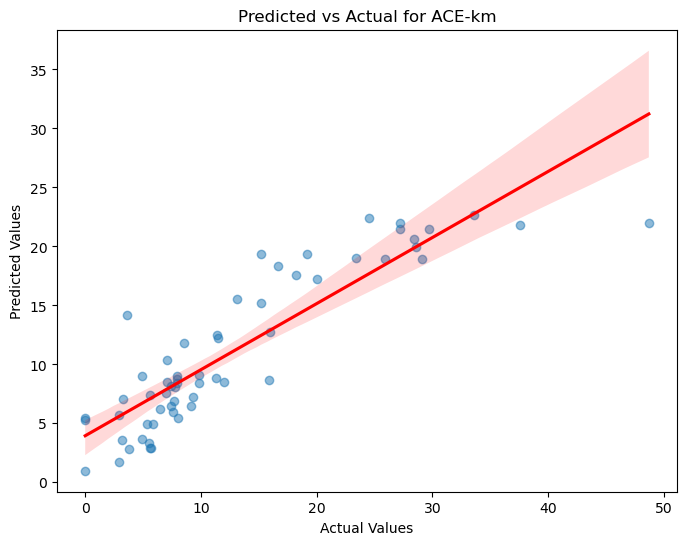

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

###############################################
# 1. Define a Dataset that Processes the Data #
###############################################

class TabularDataset(Dataset):
    """
    A dataset that accepts a DataFrame and separates numerical and categorical features.
    The numerical features are scaled, and the categorical features are label-encoded.
    Optionally, you can pass an already fitted scaler and encoders (useful for validation data).
    """
    def __init__(self, df, cat_cols, num_cols, target_col, scaler=None, cat_encoders=None):
        self.df = df.copy().dropna().reset_index(drop=True)
        self.df = self.df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col

        if scaler is None:
            self.scaler = StandardScaler()
            self.num_data = self.scaler.fit_transform(self.df[num_cols])
        else:
            self.scaler = scaler
            self.num_data = self.scaler.transform(self.df[num_cols])
        
        self.cat_encoders = {}
        cat_data_list = []
        for col in cat_cols:
            if cat_encoders is None or col not in cat_encoders:
                le = LabelEncoder()
                encoded = le.fit_transform(self.df[col])
                self.cat_encoders[col] = le
            else:
                le = cat_encoders[col]
                self.cat_encoders[col] = le
                encoded = le.transform(self.df[col])
            cat_data_list.append(encoded.astype(np.int64))
        if len(cat_cols) > 0:
            self.cat_data = np.stack(cat_data_list, axis=1)
        else:
            self.cat_data = None
        
        self.target = self.df[target_col].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num = self.num_data[idx]
        if self.cat_data is not None:
            cat = self.cat_data[idx]
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(cat, dtype=torch.long),
                    torch.tensor(self.target[idx], dtype=torch.float32))
        else:
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(self.target[idx], dtype=torch.float32))

###########################################################
# 2. Define the TabTransformer Model for Regression Tasks #
###########################################################

class TabTransformerModel(nn.Module):
    """
    Transformer-based model for tabular regression.
    It embeds categorical features and projects numerical features into a common embedding space,
    concatenates them, and passes the combined vector through a transformer encoder and regression head.
    """
    def __init__(self, num_features, cat_cardinalities, embed_dim=32, nhead=4, num_transformer_layers=2,
                 dim_feedforward=64, dropout=0.1):
        super(TabTransformerModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, embedding_dim=embed_dim)
            for card in cat_cardinalities
        ])
        self.num_proj = nn.Linear(num_features, embed_dim)
        
        self.num_tokens = 1 + len(cat_cardinalities)
        self.transformer_input_dim = self.num_tokens * embed_dim
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.transformer_input_dim,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(self.transformer_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, num_data, cat_data):
        num_embed = self.num_proj(num_data)
        
        if cat_data is not None:
            cat_embeds = [emb(cat_data[:, i]) for i, emb in enumerate(self.cat_embeddings)]
            tokens = [num_embed] + cat_embeds
        else:
            tokens = [num_embed]
        
        tokens = torch.stack(tokens, dim=1)
        batch_size = tokens.size(0)
        tokens = tokens.view(batch_size, -1)
        tokens = tokens.unsqueeze(0)
        transformer_out = self.transformer_encoder(tokens)
        transformer_out = transformer_out.squeeze(0)
        output = self.fc(transformer_out)
        return output.squeeze(1)

##################################################
# 3. Cross-Validation with the TabTransformer Model #
##################################################

def cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=100, batch_size=32, learning_rate=0.001):
    """
    Splits the DataFrame into training/validation folds.
    For each fold, fits the dataset (with scaling and encoding on training data) and trains the transformer.
    Reports MSE and R^2 for each fold and plots the overall predicted vs. actual values.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold+1}/{k_folds}")
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = TabularDataset(df_train, cat_cols, num_cols, target_column)
        val_dataset = TabularDataset(df_val, cat_cols, num_cols, target_column,
                                     scaler=train_dataset.scaler, cat_encoders=train_dataset.cat_encoders)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        cat_cardinalities = []
        for col in cat_cols:
            cardinality = len(train_dataset.cat_encoders[col].classes_)
            cat_cardinalities.append(cardinality)
        
        input_dim = len(num_cols)
        model = TabTransformerModel(num_features=input_dim, cat_cardinalities=cat_cardinalities).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, X_cat)
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, None)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for batch in val_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    preds = model(X_num, X_cat).cpu().numpy()
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    preds = model(X_num, None).cpu().numpy()
                val_preds.extend(preds)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        
        print(f"Fold {fold+1} Results: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"\nFinal Cross-Validation Results: Mean MSE = {np.mean(mse_scores):.4f}, Mean R^2 = {np.mean(r2_scores):.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

##############################################
# 4. Load Data and Run Cross-Validation        #
##############################################

df = pd.read_csv("Data/New_data.csv")

target_column = "ACE-km"
cat_cols = []
num_cols = [col for col in df.columns if col not in target_columns]

# Run 5-fold cross-validation
cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=50, batch_size=32, learning_rate=0.001)


Fold 1/5
Epoch [1/100] Loss: 286.4261
Epoch [2/100] Loss: 273.0715
Epoch [3/100] Loss: 234.0260
Epoch [4/100] Loss: 253.3998
Epoch [5/100] Loss: 247.9752
Epoch [6/100] Loss: 244.3619
Epoch [7/100] Loss: 211.8664
Epoch [8/100] Loss: 261.9466
Epoch [9/100] Loss: 250.1306
Epoch [10/100] Loss: 208.7393
Epoch [11/100] Loss: 239.7485
Epoch [12/100] Loss: 207.7686


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [13/100] Loss: 200.8699
Epoch [14/100] Loss: 164.0933
Epoch [15/100] Loss: 168.0950
Epoch [16/100] Loss: 208.6593
Epoch [17/100] Loss: 187.8870
Epoch [18/100] Loss: 146.3324
Epoch [19/100] Loss: 168.2043
Epoch [20/100] Loss: 157.8756
Epoch [21/100] Loss: 192.1070
Epoch [22/100] Loss: 176.4754
Epoch [23/100] Loss: 138.1278
Epoch [24/100] Loss: 128.9027
Epoch [25/100] Loss: 131.6844
Epoch [26/100] Loss: 128.8143
Epoch [27/100] Loss: 126.2163
Epoch [28/100] Loss: 119.8177
Epoch [29/100] Loss: 96.2268
Epoch [30/100] Loss: 119.1319
Epoch [31/100] Loss: 117.5802
Epoch [32/100] Loss: 119.9052
Epoch [33/100] Loss: 85.4300
Epoch [34/100] Loss: 83.0568
Epoch [35/100] Loss: 87.7379
Epoch [36/100] Loss: 72.3097
Epoch [37/100] Loss: 88.1233
Epoch [38/100] Loss: 68.6732
Epoch [39/100] Loss: 73.1350
Epoch [40/100] Loss: 53.2833
Epoch [41/100] Loss: 55.3358
Epoch [42/100] Loss: 51.0752
Epoch [43/100] Loss: 66.9701
Epoch [44/100] Loss: 56.5846
Epoch [45/100] Loss: 54.5470
Epoch [46/100] Loss: 35.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] Loss: 242.2041
Epoch [2/100] Loss: 250.0895
Epoch [3/100] Loss: 280.2639
Epoch [4/100] Loss: 243.8050
Epoch [5/100] Loss: 250.9832
Epoch [6/100] Loss: 255.4514
Epoch [7/100] Loss: 233.8862
Epoch [8/100] Loss: 248.6712
Epoch [9/100] Loss: 238.3401
Epoch [10/100] Loss: 237.8312
Epoch [11/100] Loss: 213.1894
Epoch [12/100] Loss: 260.9467
Epoch [13/100] Loss: 194.5478
Epoch [14/100] Loss: 195.7236
Epoch [15/100] Loss: 228.0267
Epoch [16/100] Loss: 203.2739
Epoch [17/100] Loss: 243.6894
Epoch [18/100] Loss: 163.4887
Epoch [19/100] Loss: 145.4273
Epoch [20/100] Loss: 167.3739
Epoch [21/100] Loss: 202.1534
Epoch [22/100] Loss: 168.0033
Epoch [23/100] Loss: 184.7110
Epoch [24/100] Loss: 138.1370
Epoch [25/100] Loss: 142.1377
Epoch [26/100] Loss: 117.0913
Epoch [27/100] Loss: 126.0461
Epoch [28/100] Loss: 135.8111
Epoch [29/100] Loss: 127.9003
Epoch [30/100] Loss: 121.0548
Epoch [31/100] Loss: 101.4630
Epoch [32/100] Loss: 128.7454
Epoch [33/100] Loss: 98.7526
Epoch [34/100] Loss:

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] Loss: 290.7080
Epoch [2/100] Loss: 302.7598
Epoch [3/100] Loss: 299.1425
Epoch [4/100] Loss: 266.0805
Epoch [5/100] Loss: 275.4080
Epoch [6/100] Loss: 281.5329
Epoch [7/100] Loss: 265.6152
Epoch [8/100] Loss: 235.8126
Epoch [9/100] Loss: 253.8839
Epoch [10/100] Loss: 243.2902
Epoch [11/100] Loss: 225.3239
Epoch [12/100] Loss: 249.7361
Epoch [13/100] Loss: 235.0480
Epoch [14/100] Loss: 236.9218
Epoch [15/100] Loss: 193.8073
Epoch [16/100] Loss: 194.4137
Epoch [17/100] Loss: 200.2532
Epoch [18/100] Loss: 218.1327
Epoch [19/100] Loss: 176.7491
Epoch [20/100] Loss: 201.1569
Epoch [21/100] Loss: 191.6796
Epoch [22/100] Loss: 177.2192
Epoch [23/100] Loss: 157.9766
Epoch [24/100] Loss: 158.1908
Epoch [25/100] Loss: 144.5811
Epoch [26/100] Loss: 162.6801
Epoch [27/100] Loss: 136.4819
Epoch [28/100] Loss: 134.5933
Epoch [29/100] Loss: 151.4320
Epoch [30/100] Loss: 119.6842
Epoch [31/100] Loss: 121.7797
Epoch [32/100] Loss: 113.5827
Epoch [33/100] Loss: 121.6992
Epoch [34/100] Loss

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] Loss: 232.1064
Epoch [2/100] Loss: 275.7865
Epoch [3/100] Loss: 217.5691
Epoch [4/100] Loss: 239.9523
Epoch [5/100] Loss: 223.7129
Epoch [6/100] Loss: 204.0681
Epoch [7/100] Loss: 214.2428
Epoch [8/100] Loss: 185.1270
Epoch [9/100] Loss: 195.8457
Epoch [10/100] Loss: 189.6092
Epoch [11/100] Loss: 179.0374
Epoch [12/100] Loss: 173.4889
Epoch [13/100] Loss: 178.7550
Epoch [14/100] Loss: 201.4008
Epoch [15/100] Loss: 196.6399
Epoch [16/100] Loss: 180.0883
Epoch [17/100] Loss: 147.7993
Epoch [18/100] Loss: 134.4670
Epoch [19/100] Loss: 165.2114
Epoch [20/100] Loss: 149.5266
Epoch [21/100] Loss: 151.6266
Epoch [22/100] Loss: 113.2449
Epoch [23/100] Loss: 110.5832
Epoch [24/100] Loss: 116.2240
Epoch [25/100] Loss: 132.1741
Epoch [26/100] Loss: 100.6089
Epoch [27/100] Loss: 115.1648
Epoch [28/100] Loss: 91.5453
Epoch [29/100] Loss: 111.8435
Epoch [30/100] Loss: 105.9093
Epoch [31/100] Loss: 79.4605
Epoch [32/100] Loss: 70.0812
Epoch [33/100] Loss: 76.1273
Epoch [34/100] Loss: 79

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100] Loss: 249.7067
Epoch [2/100] Loss: 241.4015
Epoch [3/100] Loss: 213.8593
Epoch [4/100] Loss: 210.2640
Epoch [5/100] Loss: 195.7044
Epoch [6/100] Loss: 226.3450
Epoch [7/100] Loss: 199.5449
Epoch [8/100] Loss: 191.1822
Epoch [9/100] Loss: 183.2490
Epoch [10/100] Loss: 176.9042
Epoch [11/100] Loss: 160.4095
Epoch [12/100] Loss: 149.9954
Epoch [13/100] Loss: 174.7958
Epoch [14/100] Loss: 172.0731
Epoch [15/100] Loss: 183.5930
Epoch [16/100] Loss: 188.1430
Epoch [17/100] Loss: 165.0760
Epoch [18/100] Loss: 157.3486
Epoch [19/100] Loss: 144.1753
Epoch [20/100] Loss: 157.8579
Epoch [21/100] Loss: 127.3381
Epoch [22/100] Loss: 118.9812
Epoch [23/100] Loss: 136.5134
Epoch [24/100] Loss: 99.9970
Epoch [25/100] Loss: 107.4633
Epoch [26/100] Loss: 105.0090
Epoch [27/100] Loss: 103.2998
Epoch [28/100] Loss: 85.9406
Epoch [29/100] Loss: 102.2249
Epoch [30/100] Loss: 76.9007
Epoch [31/100] Loss: 77.1194
Epoch [32/100] Loss: 90.2967
Epoch [33/100] Loss: 70.0558
Epoch [34/100] Loss: 82.9

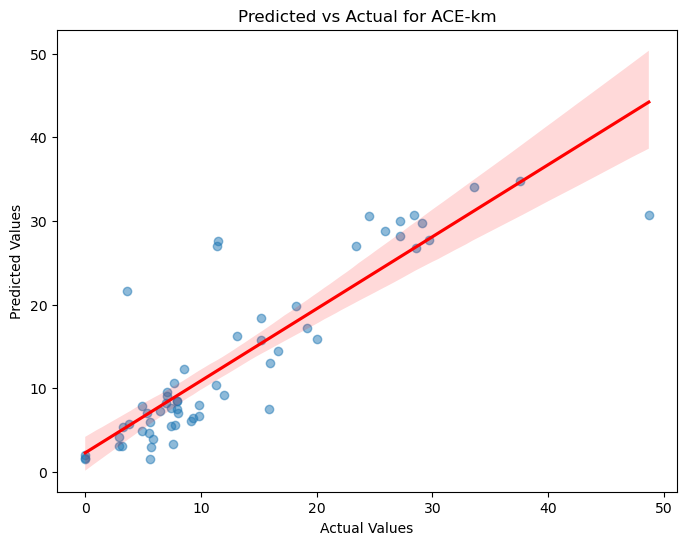

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

###############################################
# 1. Define a Dataset that Processes the Data #
###############################################

class TabularDataset(Dataset):
    """
    A dataset that accepts a DataFrame and separates numerical and categorical features.
    The numerical features are scaled, and the categorical features are label-encoded.
    Optionally, you can pass an already fitted scaler and encoders (useful for validation data).
    """
    def __init__(self, df, cat_cols, num_cols, target_col, scaler=None, cat_encoders=None):
        self.df = df.copy().dropna().reset_index(drop=True)
        self.df = self.df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col

        if scaler is None:
            self.scaler = StandardScaler()
            self.num_data = self.scaler.fit_transform(self.df[num_cols])
        else:
            self.scaler = scaler
            self.num_data = self.scaler.transform(self.df[num_cols])
        
        self.cat_encoders = {}
        cat_data_list = []
        for col in cat_cols:
            if cat_encoders is None or col not in cat_encoders:
                le = LabelEncoder()
                encoded = le.fit_transform(self.df[col])
                self.cat_encoders[col] = le
            else:
                le = cat_encoders[col]
                self.cat_encoders[col] = le
                encoded = le.transform(self.df[col])
            cat_data_list.append(encoded.astype(np.int64))
        if len(cat_cols) > 0:
            self.cat_data = np.stack(cat_data_list, axis=1)
        else:
            self.cat_data = None
        
        self.target = self.df[target_col].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num = self.num_data[idx]
        if self.cat_data is not None:
            cat = self.cat_data[idx]
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(cat, dtype=torch.long),
                    torch.tensor(self.target[idx], dtype=torch.float32))
        else:
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(self.target[idx], dtype=torch.float32))

###########################################################
# 2. Define the TabTransformer Model for Regression Tasks #
###########################################################

class TabTransformerModel(nn.Module):
    """
    Transformer-based model for tabular regression.
    It embeds categorical features and projects numerical features into a common embedding space,
    concatenates them, and passes the combined vector through a transformer encoder and regression head.
    """
    def __init__(self, num_features, cat_cardinalities, embed_dim=32, nhead=4, num_transformer_layers=2,
                 dim_feedforward=64, dropout=0.1):
        super(TabTransformerModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, embedding_dim=embed_dim)
            for card in cat_cardinalities
        ])
        self.num_proj = nn.Linear(num_features, embed_dim)
        
        self.num_tokens = 1 + len(cat_cardinalities)
        self.transformer_input_dim = self.num_tokens * embed_dim
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.transformer_input_dim,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(self.transformer_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, num_data, cat_data):
        num_embed = self.num_proj(num_data)
        
        if cat_data is not None:
            cat_embeds = [emb(cat_data[:, i]) for i, emb in enumerate(self.cat_embeddings)]
            tokens = [num_embed] + cat_embeds
        else:
            tokens = [num_embed]
        
        tokens = torch.stack(tokens, dim=1)
        batch_size = tokens.size(0)
        tokens = tokens.view(batch_size, -1)
        tokens = tokens.unsqueeze(0)
        transformer_out = self.transformer_encoder(tokens)
        transformer_out = transformer_out.squeeze(0)
        output = self.fc(transformer_out)
        return output.squeeze(1)

##################################################
# 3. Cross-Validation with the TabTransformer Model #
##################################################

def cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=100, batch_size=32, learning_rate=0.001):
    """
    Splits the DataFrame into training/validation folds.
    For each fold, fits the dataset (with scaling and encoding on training data) and trains the transformer.
    Reports MSE and R^2 for each fold and plots the overall predicted vs. actual values.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold+1}/{k_folds}")
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = TabularDataset(df_train, cat_cols, num_cols, target_column)
        val_dataset = TabularDataset(df_val, cat_cols, num_cols, target_column,
                                     scaler=train_dataset.scaler, cat_encoders=train_dataset.cat_encoders)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        cat_cardinalities = []
        for col in cat_cols:
            cardinality = len(train_dataset.cat_encoders[col].classes_)
            cat_cardinalities.append(cardinality)
        
        input_dim = len(num_cols)
        model = TabTransformerModel(num_features=input_dim, cat_cardinalities=cat_cardinalities).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, X_cat)
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, None)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for batch in val_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    preds = model(X_num, X_cat).cpu().numpy()
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    preds = model(X_num, None).cpu().numpy()
                val_preds.extend(preds)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        
        print(f"Fold {fold+1} Results: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"\nFinal Cross-Validation Results: Mean MSE = {np.mean(mse_scores):.4f}, Mean R^2 = {np.mean(r2_scores):.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

##############################################
# 4. Load Data and Run Cross-Validation        #
##############################################

df = pd.read_csv("Data/New_data.csv")

target_column = "ACE-km"
cat_cols = []
num_cols = [col for col in df.columns if col not in target_columns]

# Run 5-fold cross-validation
cross_validate(df, target_column, cat_cols, num_cols, k_folds=5, epochs=100, batch_size=32, learning_rate=0.001)

## FT Transformer [Feature Token Transformer]


Fold 1/5


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 305.7304
Epoch [2/50] Loss: 230.0509
Epoch [3/50] Loss: 265.3031
Epoch [4/50] Loss: 229.9188
Epoch [5/50] Loss: 213.5072
Epoch [6/50] Loss: 255.5636
Epoch [7/50] Loss: 222.7105
Epoch [8/50] Loss: 196.2025
Epoch [9/50] Loss: 212.7117
Epoch [10/50] Loss: 184.4993
Epoch [11/50] Loss: 184.1244
Epoch [12/50] Loss: 152.7584
Epoch [13/50] Loss: 172.8400
Epoch [14/50] Loss: 154.7293
Epoch [15/50] Loss: 132.9687
Epoch [16/50] Loss: 132.7956
Epoch [17/50] Loss: 133.1608
Epoch [18/50] Loss: 131.5889
Epoch [19/50] Loss: 127.5483
Epoch [20/50] Loss: 113.0838
Epoch [21/50] Loss: 122.4860
Epoch [22/50] Loss: 138.8350
Epoch [23/50] Loss: 104.2575
Epoch [24/50] Loss: 114.6757
Epoch [25/50] Loss: 139.5375
Epoch [26/50] Loss: 127.8335
Epoch [27/50] Loss: 116.4587
Epoch [28/50] Loss: 124.5617
Epoch [29/50] Loss: 104.9909
Epoch [30/50] Loss: 98.2415
Epoch [31/50] Loss: 123.9037
Epoch [32/50] Loss: 117.7980
Epoch [33/50] Loss: 113.9442
Epoch [34/50] Loss: 104.0953
Epoch [35/50] Loss: 110.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 260.7740
Epoch [2/50] Loss: 262.9759
Epoch [3/50] Loss: 267.9963
Epoch [4/50] Loss: 227.5487
Epoch [5/50] Loss: 248.7641
Epoch [6/50] Loss: 209.3439
Epoch [7/50] Loss: 259.9644
Epoch [8/50] Loss: 214.2260
Epoch [9/50] Loss: 235.8104
Epoch [10/50] Loss: 188.3872
Epoch [11/50] Loss: 168.0657
Epoch [12/50] Loss: 176.9776
Epoch [13/50] Loss: 200.4011
Epoch [14/50] Loss: 169.3612
Epoch [15/50] Loss: 163.3212
Epoch [16/50] Loss: 151.5135
Epoch [17/50] Loss: 130.9328
Epoch [18/50] Loss: 126.8735
Epoch [19/50] Loss: 157.0070
Epoch [20/50] Loss: 167.7419
Epoch [21/50] Loss: 121.5596
Epoch [22/50] Loss: 142.5785
Epoch [23/50] Loss: 131.1711
Epoch [24/50] Loss: 141.5049
Epoch [25/50] Loss: 125.8101
Epoch [26/50] Loss: 113.0270
Epoch [27/50] Loss: 136.3529
Epoch [28/50] Loss: 108.0179
Epoch [29/50] Loss: 112.1262
Epoch [30/50] Loss: 112.2572
Epoch [31/50] Loss: 98.7370
Epoch [32/50] Loss: 121.4925
Epoch [33/50] Loss: 99.3457
Epoch [34/50] Loss: 116.7870
Epoch [35/50] Loss: 99.28

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 306.2820
Epoch [2/50] Loss: 266.0710
Epoch [3/50] Loss: 225.2225
Epoch [4/50] Loss: 241.2364
Epoch [5/50] Loss: 224.2925
Epoch [6/50] Loss: 223.3595
Epoch [7/50] Loss: 238.5449
Epoch [8/50] Loss: 237.1383
Epoch [9/50] Loss: 221.5499
Epoch [10/50] Loss: 243.5201
Epoch [11/50] Loss: 182.1683
Epoch [12/50] Loss: 182.4766
Epoch [13/50] Loss: 185.3837
Epoch [14/50] Loss: 186.3720
Epoch [15/50] Loss: 159.9807
Epoch [16/50] Loss: 177.8019
Epoch [17/50] Loss: 178.7041
Epoch [18/50] Loss: 163.4600
Epoch [19/50] Loss: 133.1336
Epoch [20/50] Loss: 131.1272
Epoch [21/50] Loss: 142.8844
Epoch [22/50] Loss: 150.2098
Epoch [23/50] Loss: 125.3972
Epoch [24/50] Loss: 115.7577
Epoch [25/50] Loss: 130.4238
Epoch [26/50] Loss: 98.6066
Epoch [27/50] Loss: 131.2009
Epoch [28/50] Loss: 107.3011
Epoch [29/50] Loss: 107.7338
Epoch [30/50] Loss: 136.9145
Epoch [31/50] Loss: 105.1451
Epoch [32/50] Loss: 124.3574
Epoch [33/50] Loss: 105.1156
Epoch [34/50] Loss: 105.7888
Epoch [35/50] Loss: 126.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 212.3560
Epoch [2/50] Loss: 262.6602
Epoch [3/50] Loss: 198.5786
Epoch [4/50] Loss: 198.6388
Epoch [5/50] Loss: 201.3440
Epoch [6/50] Loss: 179.0499
Epoch [7/50] Loss: 191.1586
Epoch [8/50] Loss: 164.2338
Epoch [9/50] Loss: 161.4317
Epoch [10/50] Loss: 192.2091
Epoch [11/50] Loss: 127.8884
Epoch [12/50] Loss: 163.7167
Epoch [13/50] Loss: 128.5845
Epoch [14/50] Loss: 147.5577
Epoch [15/50] Loss: 133.4327
Epoch [16/50] Loss: 147.9414
Epoch [17/50] Loss: 142.6681
Epoch [18/50] Loss: 105.1692
Epoch [19/50] Loss: 124.9892
Epoch [20/50] Loss: 106.5747
Epoch [21/50] Loss: 92.4740
Epoch [22/50] Loss: 91.5547
Epoch [23/50] Loss: 89.6283
Epoch [24/50] Loss: 93.8248
Epoch [25/50] Loss: 112.9064
Epoch [26/50] Loss: 118.8949
Epoch [27/50] Loss: 98.0247
Epoch [28/50] Loss: 116.4974
Epoch [29/50] Loss: 88.0523
Epoch [30/50] Loss: 96.9918
Epoch [31/50] Loss: 91.1535
Epoch [32/50] Loss: 92.7213
Epoch [33/50] Loss: 99.1020
Epoch [34/50] Loss: 94.6953
Epoch [35/50] Loss: 89.0371
Epoch 

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 229.5404
Epoch [2/50] Loss: 186.9426
Epoch [3/50] Loss: 201.4443
Epoch [4/50] Loss: 173.4630
Epoch [5/50] Loss: 174.5208
Epoch [6/50] Loss: 156.0400
Epoch [7/50] Loss: 166.7878
Epoch [8/50] Loss: 196.4869
Epoch [9/50] Loss: 166.7981
Epoch [10/50] Loss: 146.0452
Epoch [11/50] Loss: 131.5712
Epoch [12/50] Loss: 130.0939
Epoch [13/50] Loss: 121.8484
Epoch [14/50] Loss: 121.6233
Epoch [15/50] Loss: 122.5335
Epoch [16/50] Loss: 122.5689
Epoch [17/50] Loss: 93.1115
Epoch [18/50] Loss: 123.2840
Epoch [19/50] Loss: 91.6023
Epoch [20/50] Loss: 96.2511
Epoch [21/50] Loss: 92.0124
Epoch [22/50] Loss: 86.7616
Epoch [23/50] Loss: 90.1586
Epoch [24/50] Loss: 86.0784
Epoch [25/50] Loss: 91.2631
Epoch [26/50] Loss: 80.6620
Epoch [27/50] Loss: 73.8610
Epoch [28/50] Loss: 77.7592
Epoch [29/50] Loss: 87.2428
Epoch [30/50] Loss: 95.8408
Epoch [31/50] Loss: 87.7158
Epoch [32/50] Loss: 82.7212
Epoch [33/50] Loss: 86.2991
Epoch [34/50] Loss: 94.6760
Epoch [35/50] Loss: 97.6058
Epoch [36/50

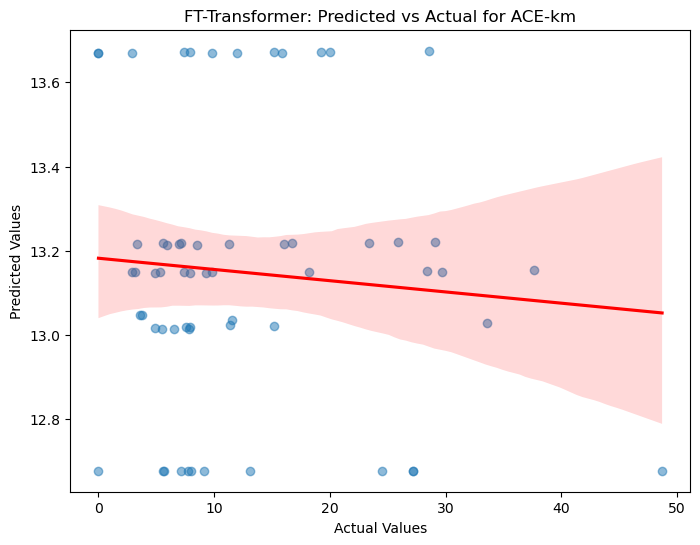

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

###############################################################################
# 1. Dataset Class for Tabular Data (Numerical & Categorical)                 #
###############################################################################

# List of target columns – these are assumed to be non-feature columns.
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

class TabularDataset(Dataset):
    """
    Dataset for tabular data that:
      - Drops missing values and converts all columns to numeric.
      - Scales numerical features using StandardScaler.
      - Label-encodes categorical features.
    If any categorical features are present, returns a tuple:
      (numerical_tensor, categorical_tensor, target_tensor)
    Otherwise, returns:
      (numerical_tensor, target_tensor)
    """
    def __init__(self, df, cat_cols, num_cols, target_col, scaler=None, cat_encoders=None):
        self.df = df.copy().dropna().reset_index(drop=True)
        # Ensure numeric conversion and fill any remaining missing values with 0.
        self.df = self.df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col
        
        # Scale numerical features
        if scaler is None:
            self.scaler = StandardScaler()
            self.num_data = self.scaler.fit_transform(self.df[num_cols])
        else:
            self.scaler = scaler
            self.num_data = self.scaler.transform(self.df[num_cols])
        
        # Process categorical features if provided.
        self.cat_encoders = {}
        cat_data_list = []
        for col in cat_cols:
            if cat_encoders is None or col not in cat_encoders:
                le = LabelEncoder()
                encoded = le.fit_transform(self.df[col])
                self.cat_encoders[col] = le
            else:
                le = cat_encoders[col]
                self.cat_encoders[col] = le
                encoded = le.transform(self.df[col])
            cat_data_list.append(encoded.astype(np.int64))
        if len(cat_cols) > 0:
            self.cat_data = np.stack(cat_data_list, axis=1)
        else:
            self.cat_data = None
            
        self.target = self.df[target_col].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num = self.num_data[idx]
        if self.cat_data is not None:
            cat = self.cat_data[idx]
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(cat, dtype=torch.long),
                    torch.tensor(self.target[idx], dtype=torch.float32))
        else:
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(self.target[idx], dtype=torch.float32))


###############################################################################
# 2. FT-Transformer Model for Tabular Regression                             #
###############################################################################

class FTTransformerModel(nn.Module):
    """
    FT-Transformer for tabular regression.
    
    - Each numerical feature (a scalar) is projected to a d_token–dimensional token
      via a dedicated linear layer.
    - Each categorical feature is embedded via an embedding layer.
    - A learnable [CLS] token is prepended to the token sequence.
    - Learnable positional embeddings are added.
    - The full sequence is passed through a transformer encoder.
    - The final representation of the [CLS] token is used by an MLP head for regression.
    """
    def __init__(self, num_num_features, cat_cardinalities, d_token=64, nhead=8,
                 num_layers=4, dropout=0.1, mlp_hidden=64):
        super(FTTransformerModel, self).__init__()
        self.d_token = d_token
        
        # For each numerical feature, project its scalar to a d_token vector.
        self.num_tokens = nn.ModuleList([nn.Linear(1, d_token) for _ in range(num_num_features)])
        
        # For each categorical feature, create an embedding layer.
        self.cat_tokens = nn.ModuleList([nn.Embedding(card, d_token) for card in cat_cardinalities])
        
        # Total number of feature tokens.
        self.total_feature_tokens = len(self.num_tokens) + len(self.cat_tokens)
        # Learnable [CLS] token (will represent the aggregate information).
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        
        # Learnable positional embeddings for the entire token sequence (CLS + feature tokens).
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.total_feature_tokens + 1, d_token))
        
        # Transformer encoder.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_token, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # MLP head for regression (using the [CLS] token output).
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        # Initialize positional embeddings and [CLS] token.
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        # Initialize numerical projection layers.
        for layer in self.num_tokens:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
        # Initialize categorical embeddings.
        for emb in self.cat_tokens:
            nn.init.uniform_(emb.weight, -0.1, 0.1)
            
    def forward(self, num_data, cat_data):
        batch_size = num_data.size(0)
        tokens = []
        
        # Process numerical features: project each scalar into a token.
        for i, proj in enumerate(self.num_tokens):
            token = proj(num_data[:, i:i+1])  # (batch, d_token)
            tokens.append(token.unsqueeze(1)) # (batch, 1, d_token)
        
        # Process categorical features (if any).
        if cat_data is not None and cat_data.shape[1] > 0:
            for i, emb in enumerate(self.cat_tokens):
                token = emb(cat_data[:, i])  # (batch, d_token)
                tokens.append(token.unsqueeze(1)) # (batch, 1, d_token)
        
        # Concatenate all feature tokens: (batch, total_feature_tokens, d_token)
        tokens = torch.cat(tokens, dim=1)
        
        # Prepend the [CLS] token.
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, d_token)
        tokens = torch.cat([cls_tokens, tokens], dim=1)  # (batch, total_feature_tokens+1, d_token)
        
        # Add positional embeddings.
        tokens = tokens + self.pos_embedding  # (batch, total_feature_tokens+1, d_token)
        
        # Transformer expects input shape: (sequence_length, batch, d_token)
        tokens = tokens.transpose(0, 1)  # (sequence_length, batch, d_token)
        encoded_tokens = self.transformer(tokens)  # (sequence_length, batch, d_token)
        
        # Use the [CLS] token output for regression.
        cls_out = encoded_tokens[0]  # (batch, d_token)
        out = self.mlp_head(cls_out)  # (batch, 1)
        return out.squeeze(1)


###############################################################################
# 3. Cross-Validation Training Function for FT-Transformer                    #
###############################################################################

def cross_validate_ft(df, target_column, cat_cols, num_cols, k_folds=5,
                      epochs=100, batch_size=32, learning_rate=0.001):
    """
    Splits the DataFrame into training/validation folds.
    For each fold:
      - The training fold fits the scaler and encoders.
      - The same scaler/encoders are used for the validation fold.
      - The FT-Transformer model is trained and evaluated.
    MSE and R² are reported for each fold, and a scatter plot of all predictions is shown.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold+1}/{k_folds}")
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        
        # Prepare training dataset (fits scaler/encoders)
        train_dataset = TabularDataset(df_train, cat_cols, num_cols, target_column)
        # Prepare validation dataset (use training scalers/encoders)
        val_dataset = TabularDataset(df_val, cat_cols, num_cols, target_column,
                                     scaler=train_dataset.scaler,
                                     cat_encoders=train_dataset.cat_encoders)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Number of numerical features.
        num_num_features = len(num_cols)
        # Compute cardinalities for each categorical column.
        cat_cardinalities = []
        for col in cat_cols:
            cardinality = len(train_dataset.cat_encoders[col].classes_)
            cat_cardinalities.append(cardinality)
        
        # Instantiate the FT-Transformer model.
        model = FTTransformerModel(num_num_features=num_num_features,
                                   cat_cardinalities=cat_cardinalities,
                                   d_token=64, nhead=8, num_layers=4,
                                   dropout=0.1, mlp_hidden=64).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop.
        model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, X_cat)
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, None)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")
        
        # Validation loop.
        model.eval()
        fold_preds, fold_actuals = [], []
        with torch.no_grad():
            for batch in val_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y_batch = batch
                    X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                    preds = model(X_num, X_cat).cpu().numpy()
                else:
                    X_num, y_batch = batch
                    X_num, y_batch = X_num.to(device), y_batch.to(device)
                    preds = model(X_num, None).cpu().numpy()
                fold_preds.extend(preds)
                fold_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(fold_actuals, fold_preds)
        r2 = r2_score(fold_actuals, fold_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        all_actuals.extend(fold_actuals)
        all_predictions.extend(fold_preds)
        
        print(f"Fold {fold+1} Results: MSE = {mse:.4f}, R² = {r2:.4f}")
    
    print(f"\nFinal Cross-Validation Results: Mean MSE = {np.mean(mse_scores):.4f}, Mean R² = {np.mean(r2_scores):.4f}")
    
    # Scatter plot: Predicted vs Actual.
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"FT-Transformer: Predicted vs Actual for {target_column}")
    plt.show()


###############################################################################
# 4. Main: Load Data and Run Cross-Validation with FT-Transformer              #
###############################################################################

if __name__ == "__main__":
    # Load your dataset from CSV (update the file path if necessary)
    df = pd.read_csv("Data/New_data.csv")
    
    # Specify the target column to predict.
    target_column = "ACE-km"
    
    # Define your categorical and numerical feature columns.
    # Here, we assume that all columns not listed in target_columns are features.
    # Update 'cat_cols' if you have categorical features (e.g., OTU identifiers).
    cat_cols = []  # Example: ['OTU1', 'OTU2']
    num_cols = [col for col in df.columns if col not in target_columns]
    
    # Run 5-fold cross-validation using the FT-Transformer model.
    cross_validate_ft(df, target_column, cat_cols, num_cols,
                      k_folds=5, epochs=50, batch_size=32, learning_rate=0.001)


## SAINT: Self-Attention Interpretable Tabular Learning


Fold 1/5


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 259.2852
Epoch [2/50] Loss: 278.5998
Epoch [3/50] Loss: 273.0726
Epoch [4/50] Loss: 220.0087
Epoch [5/50] Loss: 222.2054
Epoch [6/50] Loss: 201.1921
Epoch [7/50] Loss: 205.0963
Epoch [8/50] Loss: 178.2590
Epoch [9/50] Loss: 192.5274
Epoch [10/50] Loss: 207.2343
Epoch [11/50] Loss: 199.4961
Epoch [12/50] Loss: 162.6720
Epoch [13/50] Loss: 165.2275
Epoch [14/50] Loss: 172.8351
Epoch [15/50] Loss: 167.7260
Epoch [16/50] Loss: 133.2543
Epoch [17/50] Loss: 157.1933
Epoch [18/50] Loss: 122.0915
Epoch [19/50] Loss: 147.3533
Epoch [20/50] Loss: 130.9598
Epoch [21/50] Loss: 122.7262
Epoch [22/50] Loss: 103.7509
Epoch [23/50] Loss: 118.3639
Epoch [24/50] Loss: 133.6392
Epoch [25/50] Loss: 102.3566
Epoch [26/50] Loss: 115.4204
Epoch [27/50] Loss: 122.4601
Epoch [28/50] Loss: 97.7337
Epoch [29/50] Loss: 141.1029
Epoch [30/50] Loss: 110.0960
Epoch [31/50] Loss: 104.7474
Epoch [32/50] Loss: 121.7562
Epoch [33/50] Loss: 120.2834
Epoch [34/50] Loss: 104.3891
Epoch [35/50] Loss: 110.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 291.3329
Epoch [2/50] Loss: 218.3323
Epoch [3/50] Loss: 254.8254
Epoch [4/50] Loss: 265.8323
Epoch [5/50] Loss: 195.7363
Epoch [6/50] Loss: 199.8859
Epoch [7/50] Loss: 243.1354
Epoch [8/50] Loss: 184.2483
Epoch [9/50] Loss: 214.1587
Epoch [10/50] Loss: 165.9181
Epoch [11/50] Loss: 178.2142
Epoch [12/50] Loss: 181.6017
Epoch [13/50] Loss: 156.1953
Epoch [14/50] Loss: 192.2471
Epoch [15/50] Loss: 182.2687
Epoch [16/50] Loss: 177.9821
Epoch [17/50] Loss: 154.5840
Epoch [18/50] Loss: 166.8564
Epoch [19/50] Loss: 127.1213
Epoch [20/50] Loss: 173.1147
Epoch [21/50] Loss: 126.0587
Epoch [22/50] Loss: 111.2816
Epoch [23/50] Loss: 167.1287
Epoch [24/50] Loss: 115.2560
Epoch [25/50] Loss: 113.1883
Epoch [26/50] Loss: 113.4403
Epoch [27/50] Loss: 128.2339
Epoch [28/50] Loss: 105.0723
Epoch [29/50] Loss: 122.6321
Epoch [30/50] Loss: 97.2453
Epoch [31/50] Loss: 139.4126
Epoch [32/50] Loss: 134.1648
Epoch [33/50] Loss: 107.6533
Epoch [34/50] Loss: 101.3291
Epoch [35/50] Loss: 108.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 311.6762
Epoch [2/50] Loss: 244.3776
Epoch [3/50] Loss: 235.7319
Epoch [4/50] Loss: 271.2988
Epoch [5/50] Loss: 239.0477
Epoch [6/50] Loss: 227.2658
Epoch [7/50] Loss: 215.0796
Epoch [8/50] Loss: 208.1005
Epoch [9/50] Loss: 213.5136
Epoch [10/50] Loss: 197.5408
Epoch [11/50] Loss: 187.6589
Epoch [12/50] Loss: 187.8587
Epoch [13/50] Loss: 185.1038
Epoch [14/50] Loss: 170.2141
Epoch [15/50] Loss: 144.8509
Epoch [16/50] Loss: 150.6840
Epoch [17/50] Loss: 144.0426
Epoch [18/50] Loss: 135.6680
Epoch [19/50] Loss: 129.3674
Epoch [20/50] Loss: 119.7927
Epoch [21/50] Loss: 117.0916
Epoch [22/50] Loss: 118.7075
Epoch [23/50] Loss: 102.9694
Epoch [24/50] Loss: 113.1662
Epoch [25/50] Loss: 106.6152
Epoch [26/50] Loss: 144.4928
Epoch [27/50] Loss: 113.2471
Epoch [28/50] Loss: 101.2366
Epoch [29/50] Loss: 107.0246
Epoch [30/50] Loss: 124.4563
Epoch [31/50] Loss: 123.7037
Epoch [32/50] Loss: 109.0528
Epoch [33/50] Loss: 113.6966
Epoch [34/50] Loss: 114.4808
Epoch [35/50] Loss: 118

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 232.1669
Epoch [2/50] Loss: 272.4729
Epoch [3/50] Loss: 240.9862
Epoch [4/50] Loss: 259.4153
Epoch [5/50] Loss: 183.5528
Epoch [6/50] Loss: 185.8780
Epoch [7/50] Loss: 216.8397
Epoch [8/50] Loss: 183.5289
Epoch [9/50] Loss: 166.0826
Epoch [10/50] Loss: 201.5378
Epoch [11/50] Loss: 187.4245
Epoch [12/50] Loss: 185.1277
Epoch [13/50] Loss: 168.3951
Epoch [14/50] Loss: 148.9231
Epoch [15/50] Loss: 185.5242
Epoch [16/50] Loss: 166.4593
Epoch [17/50] Loss: 131.6833
Epoch [18/50] Loss: 153.2437
Epoch [19/50] Loss: 122.6855
Epoch [20/50] Loss: 130.4276
Epoch [21/50] Loss: 141.8529
Epoch [22/50] Loss: 101.6810
Epoch [23/50] Loss: 100.3986
Epoch [24/50] Loss: 100.4705
Epoch [25/50] Loss: 110.5024
Epoch [26/50] Loss: 90.1767
Epoch [27/50] Loss: 89.3198
Epoch [28/50] Loss: 124.0587
Epoch [29/50] Loss: 108.5871
Epoch [30/50] Loss: 93.3126
Epoch [31/50] Loss: 92.5110
Epoch [32/50] Loss: 92.2009
Epoch [33/50] Loss: 88.9188
Epoch [34/50] Loss: 93.0772
Epoch [35/50] Loss: 118.5103
E

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] Loss: 234.2248
Epoch [2/50] Loss: 211.4525
Epoch [3/50] Loss: 215.4892
Epoch [4/50] Loss: 173.4500
Epoch [5/50] Loss: 177.3563
Epoch [6/50] Loss: 162.3241
Epoch [7/50] Loss: 166.5071
Epoch [8/50] Loss: 163.2340
Epoch [9/50] Loss: 168.2175
Epoch [10/50] Loss: 160.3203
Epoch [11/50] Loss: 158.3607
Epoch [12/50] Loss: 162.5314
Epoch [13/50] Loss: 138.9073
Epoch [14/50] Loss: 138.5061
Epoch [15/50] Loss: 120.8545
Epoch [16/50] Loss: 132.7148
Epoch [17/50] Loss: 134.3880
Epoch [18/50] Loss: 108.0181
Epoch [19/50] Loss: 111.4378
Epoch [20/50] Loss: 108.9894
Epoch [21/50] Loss: 91.9525
Epoch [22/50] Loss: 89.6555
Epoch [23/50] Loss: 88.4974
Epoch [24/50] Loss: 83.5673
Epoch [25/50] Loss: 83.4060
Epoch [26/50] Loss: 81.6608
Epoch [27/50] Loss: 83.9887
Epoch [28/50] Loss: 92.0390
Epoch [29/50] Loss: 85.1787
Epoch [30/50] Loss: 81.2977
Epoch [31/50] Loss: 94.0282
Epoch [32/50] Loss: 87.7617
Epoch [33/50] Loss: 81.4055
Epoch [34/50] Loss: 95.5951
Epoch [35/50] Loss: 79.9450
Epoch [36

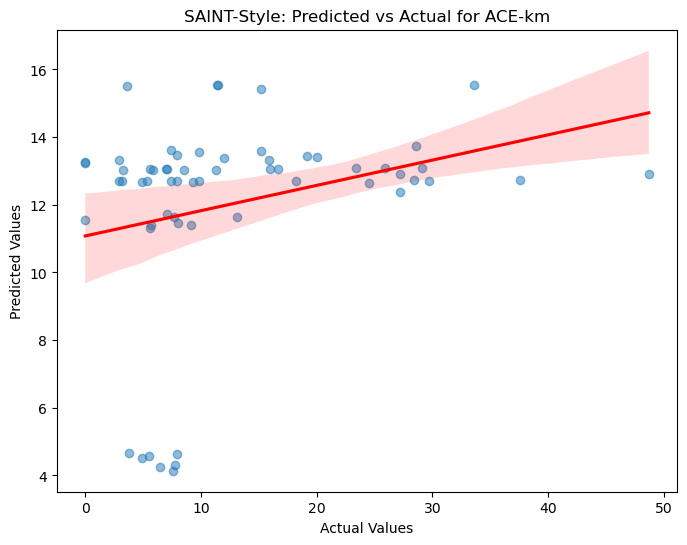

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

###############################################################################
# 1. Dataset Class for Tabular Data (Numerical & Categorical)                 #
###############################################################################

# List of target columns – these columns are assumed to be non-feature columns.
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

class TabularDataset(Dataset):
    """
    A dataset for tabular data that:
      - Drops missing values and converts all columns to numeric.
      - Scales numerical features using StandardScaler.
      - Label-encodes categorical features.
      
    Returns:
      - A tuple (numerical_tensor, categorical_tensor, target_tensor) if cat_cols is not empty.
      - Otherwise, (numerical_tensor, target_tensor).
    """
    def __init__(self, df, cat_cols, num_cols, target_col, scaler=None, cat_encoders=None):
        self.df = df.copy().dropna().reset_index(drop=True)
        # Ensure numeric conversion; fill any remaining missing values with 0.
        self.df = self.df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col
        
        # Scale numerical features.
        if scaler is None:
            self.scaler = StandardScaler()
            self.num_data = self.scaler.fit_transform(self.df[num_cols])
        else:
            self.scaler = scaler
            self.num_data = self.scaler.transform(self.df[num_cols])
        
        # Process categorical features (if any).
        self.cat_encoders = {}
        cat_data_list = []
        for col in cat_cols:
            if cat_encoders is None or col not in cat_encoders:
                le = LabelEncoder()
                encoded = le.fit_transform(self.df[col])
                self.cat_encoders[col] = le
            else:
                le = cat_encoders[col]
                self.cat_encoders[col] = le
                encoded = le.transform(self.df[col])
            cat_data_list.append(encoded.astype(np.int64))
        if len(cat_cols) > 0:
            self.cat_data = np.stack(cat_data_list, axis=1)
        else:
            self.cat_data = None
        
        self.target = self.df[target_col].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num = self.num_data[idx]
        if self.cat_data is not None:
            cat = self.cat_data[idx]
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(cat, dtype=torch.long),
                    torch.tensor(self.target[idx], dtype=torch.float32))
        else:
            return (torch.tensor(num, dtype=torch.float32),
                    torch.tensor(self.target[idx], dtype=torch.float32))

###############################################################################
# 2. SAINT-Style Transformer Model for Tabular Regression                      #
###############################################################################

class SAINTModel(nn.Module):
    """
    SAINT-Style Transformer for Tabular Regression.
    
    Key ideas:
      - Each numerical feature (a scalar) is projected via a dedicated linear layer.
      - Each categorical feature is embedded via an embedding lookup.
      - A learnable column embedding is added to each feature token (capturing feature identity).
      - A learnable [CLS] token is prepended to the sequence.
      - The sequence of tokens is passed through a transformer encoder.
      - The [CLS] token’s final representation is used for regression.
    
    Args:
      - num_num_features: Number of numerical features.
      - cat_cardinalities: List of cardinalities (number of unique values) for each categorical feature.
      - d_model: Dimensionality for all token representations.
      - nhead: Number of attention heads.
      - num_layers: Number of transformer encoder layers.
      - dropout: Dropout rate.
      - mlp_hidden: Hidden layer size for the regression head.
    """
    def __init__(self, num_num_features, cat_cardinalities, d_model=64, nhead=8,
                 num_layers=4, dropout=0.1, mlp_hidden=64):
        super(SAINTModel, self).__init__()
        self.d_model = d_model
        self.num_num_features = num_num_features
        self.num_cat_features = len(cat_cardinalities)
        self.total_features = num_num_features + self.num_cat_features

        # Numerical projection layers: one per numerical feature (scalar -> d_model)
        self.num_projections = nn.ModuleList([nn.Linear(1, d_model) for _ in range(num_num_features)])
        # Categorical embedding layers.
        self.cat_embeddings = nn.ModuleList([nn.Embedding(card, d_model) for card in cat_cardinalities])
        # Learnable column embeddings for each feature (to capture feature identity).
        # There is one column embedding per feature (numerical + categorical).
        self.col_embeddings = nn.Parameter(torch.zeros(self.total_features, d_model))
        # Learnable [CLS] token.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        
        # Transformer encoder: The input sequence will have (total_features + 1) tokens.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Regression head: uses the [CLS] token output.
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        # Initialize the [CLS] token and column embeddings.
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.col_embeddings, std=0.02)
        # Initialize numerical projection layers.
        for proj in self.num_projections:
            nn.init.xavier_uniform_(proj.weight)
            if proj.bias is not None:
                nn.init.zeros_(proj.bias)
        # Initialize categorical embeddings.
        for emb in self.cat_embeddings:
            nn.init.uniform_(emb.weight, -0.1, 0.1)
    
    def forward(self, num_data, cat_data):
        batch_size = num_data.size(0)
        tokens = []
        # Process numerical features.
        for i, proj in enumerate(self.num_projections):
            # Input shape: (batch, 1) after unsqueezing.
            token = proj(num_data[:, i:i+1])  # shape: (batch, d_model)
            # Add the corresponding column embedding (for numerical features, columns 0 to num_num_features-1)
            token = token + self.col_embeddings[i]
            tokens.append(token.unsqueeze(1))  # shape: (batch, 1, d_model)
        
        # Process categorical features (if any).
        for j, emb in enumerate(self.cat_embeddings):
            token = emb(cat_data[:, j])  # shape: (batch, d_model)
            # For categorical features, column index = num_num_features + j.
            token = token + self.col_embeddings[self.num_num_features + j]
            tokens.append(token.unsqueeze(1))
        
        # Concatenate all feature tokens: shape becomes (batch, total_features, d_model)
        tokens = torch.cat(tokens, dim=1)
        # Prepend the [CLS] token.
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # shape: (batch, 1, d_model)
        tokens = torch.cat([cls_tokens, tokens], dim=1)  # shape: (batch, total_features+1, d_model)
        
        # Transformer expects input shape: (sequence_length, batch, d_model)
        tokens = tokens.transpose(0, 1)  # shape: (total_features+1, batch, d_model)
        encoded_tokens = self.transformer(tokens)  # shape remains: (total_features+1, batch, d_model)
        encoded_tokens = encoded_tokens.transpose(0, 1)  # shape: (batch, total_features+1, d_model)
        
        # Use the [CLS] token (first token) for regression.
        cls_out = encoded_tokens[:, 0, :]  # shape: (batch, d_model)
        out = self.regressor(cls_out)  # shape: (batch, 1)
        return out.squeeze(1)

###############################################################################
# 3. Cross-Validation Training Function for SAINT-Style Model                   #
###############################################################################

def cross_validate_saint(df, target_column, cat_cols, num_cols, k_folds=5,
                         epochs=50, batch_size=32, learning_rate=0.001):
    """
    Splits the DataFrame into training/validation folds.
    For each fold:
      - The training fold is used to fit a scaler and label encoders.
      - The same scaler/encoders are applied to the validation fold.
      - The SAINT-Style model is trained and evaluated.
    Reports the MSE and R² for each fold and plots a scatter plot of predicted vs. actual values.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold+1}/{k_folds}")
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val   = df.iloc[val_idx].reset_index(drop=True)
        
        # Prepare datasets.
        train_dataset = TabularDataset(df_train, cat_cols, num_cols, target_column)
        val_dataset   = TabularDataset(df_val, cat_cols, num_cols, target_column,
                                       scaler=train_dataset.scaler,
                                       cat_encoders=train_dataset.cat_encoders)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Number of numerical features.
        num_num_features = len(num_cols)
        # Get categorical cardinalities.
        cat_cardinalities = []
        for col in cat_cols:
            cardinality = len(train_dataset.cat_encoders[col].classes_)
            cat_cardinalities.append(cardinality)
        
        # Instantiate the SAINT-Style model.
        model = SAINTModel(num_num_features=num_num_features,
                           cat_cardinalities=cat_cardinalities,
                           d_model=64, nhead=8, num_layers=4,
                           dropout=0.1, mlp_hidden=64).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop.
        model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y = batch
                    X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, X_cat)
                else:
                    X_num, y = batch
                    X_num, y = X_num.to(device), y.to(device)
                    optimizer.zero_grad()
                    preds = model(X_num, None)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")
        
        # Validation loop.
        model.eval()
        fold_preds, fold_actuals = [], []
        with torch.no_grad():
            for batch in val_loader:
                if len(cat_cols) > 0:
                    X_num, X_cat, y = batch
                    X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
                    preds = model(X_num, X_cat)
                else:
                    X_num, y = batch
                    X_num, y = X_num.to(device), y.to(device)
                    preds = model(X_num, None)
                fold_preds.extend(preds.cpu().numpy())
                fold_actuals.extend(y.cpu().numpy())
        
        mse = mean_squared_error(fold_actuals, fold_preds)
        r2  = r2_score(fold_actuals, fold_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        all_actuals.extend(fold_actuals)
        all_predictions.extend(fold_preds)
        
        print(f"Fold {fold+1} Results: MSE = {mse:.4f}, R² = {r2:.4f}")
    
    print(f"\nFinal Cross-Validation Results: Mean MSE = {np.mean(mse_scores):.4f}, Mean R² = {np.mean(r2_scores):.4f}")
    
    # Scatter plot: Predicted vs Actual.
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"SAINT-Style: Predicted vs Actual for {target_column}")
    plt.show()

###############################################################################
# 4. Main: Load Data and Run Cross-Validation with SAINT-Style Model             #
###############################################################################

if __name__ == "__main__":
    # Load your dataset from CSV (update the file path if necessary)
    df = pd.read_csv("Data/New_data.csv")
    
    # Specify the target column to predict.
    target_column = "ACE-km"
    
    # Define your categorical and numerical feature columns.
    # In this example, we assume that all columns not in target_columns are features.
    # If you have categorical features (e.g., OTU identifiers), list them in cat_cols.
    cat_cols = []  # Example: ['OTU1', 'OTU2'] if applicable
    num_cols = [col for col in df.columns if col not in target_columns]
    
    # Run cross-validation using the SAINT-Style model.
    cross_validate_saint(df, target_column, cat_cols, num_cols,
                         k_folds=5, epochs=50, batch_size=32, learning_rate=0.001)
